# Packages Import

In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/continue-file/mycsv.csv
/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv


# Data Loading

In [7]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Take Home Assignment") \
    .getOrCreate()

In [8]:
data_base = "/kaggle/input/home-credit-default-risk"

# Load all relevant files
data_files = {
    "application_train": "application_train.csv",
    "application_test": "application_test.csv",
    "bureau": "bureau.csv",
    "bureau_balance": "bureau_balance.csv",
    "previous_application": "previous_application.csv",
    "credit_card_balance": "credit_card_balance.csv",
    "POS_CASH_balance": "POS_CASH_balance.csv",
    "installments_payments": "installments_payments.csv",
    "sample_submission": "sample_submission.csv",
    "columns_description": "HomeCredit_columns_description.csv"
}

dfs = {name: spark.read.csv(f"{data_base}/{fname}", header=True, inferSchema=True) for name, fname in data_files.items()}

In [9]:
from pyspark.sql.functions import col, count, isnan, when, countDistinct

# Check for missing or NaN values
def check_missing(df):
    total = df.count()
    missing_exprs = [
        (count(when(col(c).isNull() | isnan(c), c)) / total).alias(f"{c}_pct")
        for c in df.columns
    ]
    count_exprs = [
        count(when(col(c).isNull() | isnan(c), c)).alias(f"{c}_cnt")
        for c in df.columns
    ]
    count_df = df.select(count_exprs)
    pct_df = df.select(missing_exprs)
    return count_df, pct_df, total

# Check for duplicates based on subset (usually ID)
def check_duplicates(df, subset=None):
    return df.groupBy(subset).count().filter("count > 1").count() if subset else df.count() - df.dropDuplicates().count()

# Count distinct values in a column
def check_cardinality(df, col_name):
    return df.select(countDistinct(col_name)).collect()[0][0]

# Print summary of a single DataFrame
def show_summary(df, name):
    print(f"\n=== {name} ===")
    print("Data types:")
    df.printSchema()
    print(f"Total rows: {df.count()}")

def run_quality_checks(df, name, id_column=None):
    print(f"\n\n=== Validating: {name} ===")

    # Missing values
    print("Missing values (count and %):")
    count_df, pct_df, total_rows = check_missing(df)
    
    # Convert both to Pandas and combine
    count_pd = count_df.toPandas().T.reset_index()
    count_pd.columns = ["column", "missing_count"]
    count_pd["column"] = count_pd["column"].str.replace("_cnt", "")

    pct_pd = pct_df.toPandas().T.reset_index()
    pct_pd.columns = ["column", "missing_pct"]
    pct_pd["column"] = pct_pd["column"].str.replace("_pct", "")
    pct_pd["missing_pct"] = (pct_pd["missing_pct"] * 100).round(2)

    # Merge and filter
    missing_pd = count_pd.merge(pct_pd, on="column")
    missing_pd = missing_pd[missing_pd["missing_count"] > 0]
    missing_pd = missing_pd.sort_values(by="missing_count", ascending=False)

    print(missing_pd.to_string(index=False))

    # Duplicates
    if id_column:
        dupes = check_duplicates(df, subset=None)
        print(f"Duplicate rows entries: {dupes}")

        # Cardinality
        card = check_cardinality(df, id_column)
        print(f"Unique `{id_column}` values: {card}")

    # Schema and total rows
    show_summary(df, name)



# Data Quality Check

In [10]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [11]:
from pyspark.sql import SparkSession, DataFrame, functions as F

def detect_low_cardinality_columns(df: DataFrame, threshold=20):
    """
    Fast low-cardinality detection using approx_count_distinct.
    """
    result = []
    for c, t in df.dtypes:
        uniq = df.agg(F.approx_count_distinct(c).alias('cnt')).collect()[0]['cnt']
        if uniq <= threshold:
            result.append((c, uniq, t))
    return result

def count_duplicated_row_occurrences(df: DataFrame) -> int:
    """
    Returns total number of duplicated row *occurrences* (sum of repeats),
    using xxhash64 for speed on wide/long tables.
    """
    df_h = df.withColumn("__row_hash__", F.xxhash64(*df.columns))
    dup_info = (
        df_h
        .groupBy("__row_hash__")
        .count()
        .filter(F.col("count") > 1)
        .agg(F.sum(F.col("count") - 1).alias("dup_occ"))
        .collect()[0]["dup_occ"]
    )
    return int(dup_info or 0)

def basic_profile(df: DataFrame, name: str, cardinality_threshold=20):
    print(f"\n=== {name} Basic Profile ===")
    df.printSchema()

    # total rows
    total_rows = df.count()
    print(f"Total rows: {total_rows}")

    # missing counts & percentages
    miss_exprs = [
        F.count(F.when(F.col(c).isNull() | F.isnan(c), c)).alias(c)
        for c in df.columns
    ]
    miss_counts = df.select(miss_exprs).first().asDict()
    print("Missing values (%):")
    for col, cnt in sorted(miss_counts.items(), key=lambda x: x[1], reverse=True):
        if cnt > 0:
            print(f" - {col}: {cnt} ({cnt/total_rows*100:.2f}%)")

    # duplicate SK_ID_CURR if present
    if 'SK_ID_CURR' in df.columns:
        dup_id = total_rows - df.dropDuplicates(['SK_ID_CURR']).count()
        print(f"Duplicate SK_ID_CURR: {dup_id}")

    # full-row duplicates
    dup_rows = count_duplicated_row_occurrences(df)
    print(f"Duplicate rows (entire rows): {dup_rows}")

    # low-cardinality columns
    print("Low-cardinality columns (≤ threshold):")
    low_card = detect_low_cardinality_columns(df, threshold=cardinality_threshold)
    for c, uniq, t in low_card:
        print(f" - {c} ({t}): {uniq} unique")

    return [c for c, _, _ in low_card]

def target_dist(df: DataFrame):
    print(f"\n--- TARGET distribution ---")
    df.groupBy('TARGET').count().orderBy('TARGET').show()

def num_stats_by_target(df: DataFrame, cols):
    print(f"\n--- Numeric stats by TARGET ---")
    stats = df.groupBy('TARGET').agg(
        *[F.mean(c).alias(f"mean_{c}") for c in cols],
        *[F.expr(f"percentile_approx({c}, 0.5)").alias(f"median_{c}") for c in cols]
    )
    stats.show()

def corr_matrix(df: DataFrame, cols, frac=0.01):
    import pandas as pd
    # Spark’s sample API is sample(withReplacement: bool, fraction: float, seed: int = None)
    sampled = df.select(cols).sample(False, frac)
    pd_df = sampled.toPandas()
    print("\nCorrelation matrix:")
    print(pd_df.corr())


In [12]:
#run on application_train
df_train = dfs['application_train']

basic_profile(df_train, 'application_train')
target_dist(df_train)
num_stats_by_target(df_train, ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'DAYS_BIRTH'])
corr_matrix(df_train, ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'DAYS_BIRTH', 'TARGET'])



=== application_train Basic Profile ===
root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: 

25/05/20 10:33:35 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Missing values (%):
 - COMMONAREA_AVG: 214865 (69.87%)
 - COMMONAREA_MODE: 214865 (69.87%)
 - COMMONAREA_MEDI: 214865 (69.87%)
 - NONLIVINGAPARTMENTS_AVG: 213514 (69.43%)
 - NONLIVINGAPARTMENTS_MODE: 213514 (69.43%)
 - NONLIVINGAPARTMENTS_MEDI: 213514 (69.43%)
 - FONDKAPREMONT_MODE: 210295 (68.39%)
 - LIVINGAPARTMENTS_AVG: 210199 (68.35%)
 - LIVINGAPARTMENTS_MODE: 210199 (68.35%)
 - LIVINGAPARTMENTS_MEDI: 210199 (68.35%)
 - FLOORSMIN_AVG: 208642 (67.85%)
 - FLOORSMIN_MODE: 208642 (67.85%)
 - FLOORSMIN_MEDI: 208642 (67.85%)
 - YEARS_BUILD_AVG: 204488 (66.50%)
 - YEARS_BUILD_MODE: 204488 (66.50%)
 - YEARS_BUILD_MEDI: 204488 (66.50%)
 - OWN_CAR_AGE: 202929 (65.99%)
 - LANDAREA_AVG: 182590 (59.38%)
 - LANDAREA_MODE: 182590 (59.38%)
 - LANDAREA_MEDI: 182590 (59.38%)
 - BASEMENTAREA_AVG: 179943 (58.52%)
 - BASEMENTAREA_MODE: 179943 (58.52%)
 - BASEMENTAREA_MEDI: 179943 (58.52%)
 - EXT_SOURCE_1: 173378 (56.38%)
 - NONLIVINGAREA_AVG: 169682 (55.18%)
 - NONLIVINGAREA_MODE: 169682 (55.18%)
 - NO

Duplicate SK_ID_CURR: 0


Duplicate rows (entire rows): 0
Low-cardinality columns (≤ threshold):


 - TARGET (int): 2 unique
 - NAME_CONTRACT_TYPE (string): 2 unique
 - CODE_GENDER (string): 3 unique
 - FLAG_OWN_CAR (string): 2 unique
 - FLAG_OWN_REALTY (string): 2 unique
 - CNT_CHILDREN (int): 15 unique
 - NAME_TYPE_SUITE (string): 7 unique
 - NAME_INCOME_TYPE (string): 8 unique
 - NAME_EDUCATION_TYPE (string): 5 unique
 - NAME_FAMILY_STATUS (string): 5 unique
 - NAME_HOUSING_TYPE (string): 6 unique
 - FLAG_MOBIL (int): 2 unique
 - FLAG_EMP_PHONE (int): 2 unique
 - FLAG_WORK_PHONE (int): 2 unique
 - FLAG_CONT_MOBILE (int): 2 unique
 - FLAG_PHONE (int): 2 unique
 - FLAG_EMAIL (int): 2 unique
 - OCCUPATION_TYPE (string): 17 unique
 - CNT_FAM_MEMBERS (double): 17 unique
 - REGION_RATING_CLIENT (int): 3 unique
 - REGION_RATING_CLIENT_W_CITY (int): 3 unique
 - WEEKDAY_APPR_PROCESS_START (string): 7 unique
 - REG_REGION_NOT_LIVE_REGION (int): 2 unique
 - REG_REGION_NOT_WORK_REGION (int): 2 unique
 - LIVE_REGION_NOT_WORK_REGION (int): 2 unique
 - REG_CITY_NOT_LIVE_CITY (int): 2 unique
 - 

+------+------+
|TARGET| count|
+------+------+
|     0|282686|
|     1| 24825|
+------+------+


--- Numeric stats by TARGET ---


+------+---------------------+-----------------+-------------------+-----------------------+-----------------+-----------------+
|TARGET|mean_AMT_INCOME_TOTAL|  mean_AMT_CREDIT|    mean_DAYS_BIRTH|median_AMT_INCOME_TOTAL|median_AMT_CREDIT|median_DAYS_BIRTH|
+------+---------------------+-----------------+-------------------+-----------------------+-----------------+-----------------+
|     1|   165611.76090634443| 557778.527673716| -14884.82807653575|               135000.0|         497520.0|           -14283|
|     0|    169077.7222658179|602648.2820019386|-16138.176397133215|               148500.0|         517608.0|           -15878|
+------+---------------------+-----------------+-------------------+-----------------------+-----------------+-----------------+




Correlation matrix:
                  AMT_INCOME_TOTAL  AMT_CREDIT  DAYS_BIRTH    TARGET
AMT_INCOME_TOTAL          1.000000    0.363351    0.071103 -0.020806
AMT_CREDIT                0.363351    1.000000   -0.023737 -0.021872
DAYS_BIRTH                0.071103   -0.023737    1.000000  0.083728
TARGET                   -0.020806   -0.021872    0.083728  1.000000


In [ ]:
# 5.2 Application Test
df_test = dfs['application_test']
basic_profile(df_test, 'application_test')


=== application_test Basic Profile ===
root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integer (nullable = true)
 |-- OWN_CAR_A

Missing values (%):
 - COMMONAREA_AVG: 33495 (68.72%)
 - COMMONAREA_MODE: 33495 (68.72%)
 - COMMONAREA_MEDI: 33495 (68.72%)
 - NONLIVINGAPARTMENTS_AVG: 33347 (68.41%)
 - NONLIVINGAPARTMENTS_MODE: 33347 (68.41%)
 - NONLIVINGAPARTMENTS_MEDI: 33347 (68.41%)
 - FONDKAPREMONT_MODE: 32797 (67.28%)
 - LIVINGAPARTMENTS_AVG: 32780 (67.25%)
 - LIVINGAPARTMENTS_MODE: 32780 (67.25%)
 - LIVINGAPARTMENTS_MEDI: 32780 (67.25%)
 - FLOORSMIN_AVG: 32466 (66.61%)
 - FLOORSMIN_MODE: 32466 (66.61%)
 - FLOORSMIN_MEDI: 32466 (66.61%)
 - OWN_CAR_AGE: 32312 (66.29%)
 - YEARS_BUILD_AVG: 31818 (65.28%)
 - YEARS_BUILD_MODE: 31818 (65.28%)
 - YEARS_BUILD_MEDI: 31818 (65.28%)
 - LANDAREA_AVG: 28254 (57.96%)
 - LANDAREA_MODE: 28254 (57.96%)
 - LANDAREA_MEDI: 28254 (57.96%)
 - BASEMENTAREA_AVG: 27641 (56.71%)
 - BASEMENTAREA_MODE: 27641 (56.71%)
 - BASEMENTAREA_MEDI: 27641 (56.71%)
 - NONLIVINGAREA_AVG: 26084 (53.51%)
 - NONLIVINGAREA_MODE: 26084 (53.51%)
 - NONLIVINGAREA_MEDI: 26084 (53.51%)
 - ELEVATORS_AVG: 25189 (

Duplicate SK_ID_CURR: 0


Duplicate rows (entire rows): 0
Low-cardinality columns (≤ threshold):
 - NAME_CONTRACT_TYPE (string): 2 unique
 - CODE_GENDER (string): 2 unique
 - FLAG_OWN_CAR (string): 2 unique
 - FLAG_OWN_REALTY (string): 2 unique
 - CNT_CHILDREN (int): 11 unique
 - NAME_TYPE_SUITE (string): 7 unique
 - NAME_INCOME_TYPE (string): 7 unique
 - NAME_EDUCATION_TYPE (string): 5 unique
 - NAME_FAMILY_STATUS (string): 4 unique
 - NAME_HOUSING_TYPE (string): 6 unique
 - FLAG_MOBIL (int): 2 unique
 - FLAG_EMP_PHONE (int): 2 unique
 - FLAG_WORK_PHONE (int): 2 unique
 - FLAG_CONT_MOBILE (int): 2 unique
 - FLAG_PHONE (int): 2 unique
 - FLAG_EMAIL (int): 2 unique
 - OCCUPATION_TYPE (string): 17 unique
 - CNT_FAM_MEMBERS (double): 12 unique
 - REGION_RATING_CLIENT (int): 3 unique
 - REGION_RATING_CLIENT_W_CITY (int): 4 unique
 - WEEKDAY_APPR_PROCESS_START (string): 7 unique
 - REG_REGION_NOT_LIVE_REGION (int): 2 unique
 - REG_REGION_NOT_WORK_REGION (int): 2 unique
 - LIVE_REGION_NOT_WORK_REGION (int): 2 unique


['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13

In [ ]:
# 5.3 Bureau
df_bureau = dfs['bureau']
basic_profile(df_bureau, 'bureau')


=== bureau Basic Profile ===
root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- SK_ID_BUREAU: integer (nullable = true)
 |-- CREDIT_ACTIVE: string (nullable = true)
 |-- CREDIT_CURRENCY: string (nullable = true)
 |-- DAYS_CREDIT: integer (nullable = true)
 |-- CREDIT_DAY_OVERDUE: integer (nullable = true)
 |-- DAYS_CREDIT_ENDDATE: double (nullable = true)
 |-- DAYS_ENDDATE_FACT: double (nullable = true)
 |-- AMT_CREDIT_MAX_OVERDUE: double (nullable = true)
 |-- CNT_CREDIT_PROLONG: integer (nullable = true)
 |-- AMT_CREDIT_SUM: double (nullable = true)
 |-- AMT_CREDIT_SUM_DEBT: double (nullable = true)
 |-- AMT_CREDIT_SUM_LIMIT: double (nullable = true)
 |-- AMT_CREDIT_SUM_OVERDUE: double (nullable = true)
 |-- CREDIT_TYPE: string (nullable = true)
 |-- DAYS_CREDIT_UPDATE: integer (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)

Total rows: 1716428


Missing values (%):
 - AMT_ANNUITY: 1226791 (71.47%)
 - AMT_CREDIT_MAX_OVERDUE: 1124488 (65.51%)
 - DAYS_ENDDATE_FACT: 633653 (36.92%)
 - AMT_CREDIT_SUM_LIMIT: 591780 (34.48%)
 - AMT_CREDIT_SUM_DEBT: 257669 (15.01%)
 - DAYS_CREDIT_ENDDATE: 105553 (6.15%)
 - AMT_CREDIT_SUM: 13 (0.00%)


Duplicate SK_ID_CURR: 1410617


Duplicate rows (entire rows): 0
Low-cardinality columns (≤ threshold):


 - CREDIT_ACTIVE (string): 4 unique
 - CREDIT_CURRENCY (string): 4 unique
 - CNT_CREDIT_PROLONG (int): 10 unique
 - CREDIT_TYPE (string): 15 unique


['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CNT_CREDIT_PROLONG', 'CREDIT_TYPE']

In [ ]:
# 5.4 Previous Application
df_prev = dfs['bureau_balance']
basic_profile(df_prev, 'bureau_balance')


=== bureau_balance Basic Profile ===
root
 |-- SK_ID_BUREAU: integer (nullable = true)
 |-- MONTHS_BALANCE: integer (nullable = true)
 |-- STATUS: string (nullable = true)



Total rows: 27299925


Missing values (%):


25/05/20 10:39:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/20 10:39:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/20 10:39:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/20 10:39:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/20 10:39:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/20 10:39:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/20 10:39:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/20 10:39:27 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/20 10:39:33 WARN RowBasedKeyValueBatch: Calling spill() on

Duplicate rows (entire rows): 0
Low-cardinality columns (≤ threshold):


 - STATUS (string): 8 unique


['STATUS']

In [ ]:
# 5.4 Previous Application
df_prev = dfs['previous_application']
basic_profile(df_prev, 'previous_application')


=== previous_application Basic Profile ===
root
 |-- SK_ID_PREV: integer (nullable = true)
 |-- SK_ID_CURR: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_APPLICATION: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_DOWN_PAYMENT: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- WEEKDAY_APPR_PROCESS_START: string (nullable = true)
 |-- HOUR_APPR_PROCESS_START: integer (nullable = true)
 |-- FLAG_LAST_APPL_PER_CONTRACT: string (nullable = true)
 |-- NFLAG_LAST_APPL_IN_DAY: integer (nullable = true)
 |-- RATE_DOWN_PAYMENT: double (nullable = true)
 |-- RATE_INTEREST_PRIMARY: double (nullable = true)
 |-- RATE_INTEREST_PRIVILEGED: double (nullable = true)
 |-- NAME_CASH_LOAN_PURPOSE: string (nullable = true)
 |-- NAME_CONTRACT_STATUS: string (nullable = true)
 |-- DAYS_DECISION: integer (nullable = true)
 |-- NAME_PAYMENT_TYPE: string (nullable = true)
 

Total rows: 1670214


Missing values (%):
 - RATE_INTEREST_PRIMARY: 1664263 (99.64%)
 - RATE_INTEREST_PRIVILEGED: 1664263 (99.64%)
 - AMT_DOWN_PAYMENT: 895844 (53.64%)
 - RATE_DOWN_PAYMENT: 895844 (53.64%)
 - NAME_TYPE_SUITE: 820405 (49.12%)
 - DAYS_FIRST_DRAWING: 673065 (40.30%)
 - DAYS_FIRST_DUE: 673065 (40.30%)
 - DAYS_LAST_DUE_1ST_VERSION: 673065 (40.30%)
 - DAYS_LAST_DUE: 673065 (40.30%)
 - DAYS_TERMINATION: 673065 (40.30%)
 - NFLAG_INSURED_ON_APPROVAL: 673065 (40.30%)
 - AMT_GOODS_PRICE: 385515 (23.08%)
 - AMT_ANNUITY: 372235 (22.29%)
 - CNT_PAYMENT: 372230 (22.29%)
 - PRODUCT_COMBINATION: 346 (0.02%)
 - AMT_CREDIT: 1 (0.00%)


Duplicate SK_ID_CURR: 1331357


Duplicate rows (entire rows): 0
Low-cardinality columns (≤ threshold):


 - NAME_CONTRACT_TYPE (string): 4 unique
 - WEEKDAY_APPR_PROCESS_START (string): 7 unique
 - FLAG_LAST_APPL_PER_CONTRACT (string): 2 unique
 - NFLAG_LAST_APPL_IN_DAY (int): 2 unique
 - NAME_CONTRACT_STATUS (string): 4 unique
 - NAME_PAYMENT_TYPE (string): 4 unique
 - CODE_REJECT_REASON (string): 9 unique
 - NAME_TYPE_SUITE (string): 7 unique
 - NAME_CLIENT_TYPE (string): 4 unique
 - NAME_PORTFOLIO (string): 5 unique
 - NAME_PRODUCT_TYPE (string): 3 unique
 - CHANNEL_TYPE (string): 8 unique
 - NAME_SELLER_INDUSTRY (string): 11 unique
 - NAME_YIELD_GROUP (string): 5 unique
 - PRODUCT_COMBINATION (string): 17 unique
 - NFLAG_INSURED_ON_APPROVAL (double): 2 unique


['NAME_CONTRACT_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NFLAG_LAST_APPL_IN_DAY',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE',
 'NAME_CLIENT_TYPE',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION',
 'NFLAG_INSURED_ON_APPROVAL']

In [ ]:
# 5.5 Credit Card Balance
df_ccb = dfs['credit_card_balance']
basic_profile(df_ccb, 'credit_card_balance')


=== credit_card_balance Basic Profile ===
root
 |-- SK_ID_PREV: integer (nullable = true)
 |-- SK_ID_CURR: integer (nullable = true)
 |-- MONTHS_BALANCE: integer (nullable = true)
 |-- AMT_BALANCE: double (nullable = true)
 |-- AMT_CREDIT_LIMIT_ACTUAL: integer (nullable = true)
 |-- AMT_DRAWINGS_ATM_CURRENT: double (nullable = true)
 |-- AMT_DRAWINGS_CURRENT: double (nullable = true)
 |-- AMT_DRAWINGS_OTHER_CURRENT: double (nullable = true)
 |-- AMT_DRAWINGS_POS_CURRENT: double (nullable = true)
 |-- AMT_INST_MIN_REGULARITY: double (nullable = true)
 |-- AMT_PAYMENT_CURRENT: double (nullable = true)
 |-- AMT_PAYMENT_TOTAL_CURRENT: double (nullable = true)
 |-- AMT_RECEIVABLE_PRINCIPAL: double (nullable = true)
 |-- AMT_RECIVABLE: double (nullable = true)
 |-- AMT_TOTAL_RECEIVABLE: double (nullable = true)
 |-- CNT_DRAWINGS_ATM_CURRENT: double (nullable = true)
 |-- CNT_DRAWINGS_CURRENT: integer (nullable = true)
 |-- CNT_DRAWINGS_OTHER_CURRENT: double (nullable = true)
 |-- CNT_DRAWIN

Total rows: 3840312


Missing values (%):
 - AMT_PAYMENT_CURRENT: 767988 (20.00%)
 - AMT_DRAWINGS_ATM_CURRENT: 749816 (19.52%)
 - AMT_DRAWINGS_OTHER_CURRENT: 749816 (19.52%)
 - AMT_DRAWINGS_POS_CURRENT: 749816 (19.52%)
 - CNT_DRAWINGS_ATM_CURRENT: 749816 (19.52%)
 - CNT_DRAWINGS_OTHER_CURRENT: 749816 (19.52%)
 - CNT_DRAWINGS_POS_CURRENT: 749816 (19.52%)
 - AMT_INST_MIN_REGULARITY: 305236 (7.95%)
 - CNT_INSTALMENT_MATURE_CUM: 305236 (7.95%)


Duplicate SK_ID_CURR: 3736754


Duplicate rows (entire rows): 0
Low-cardinality columns (≤ threshold):


 - CNT_DRAWINGS_OTHER_CURRENT (double): 11 unique
 - NAME_CONTRACT_STATUS (string): 7 unique


['CNT_DRAWINGS_OTHER_CURRENT', 'NAME_CONTRACT_STATUS']

In [ ]:
# 5.6 POS_CASH Balance
df_pos = dfs['POS_CASH_balance']
basic_profile(df_pos, 'POS_CASH_balance')


=== POS_CASH_balance Basic Profile ===
root
 |-- SK_ID_PREV: integer (nullable = true)
 |-- SK_ID_CURR: integer (nullable = true)
 |-- MONTHS_BALANCE: integer (nullable = true)
 |-- CNT_INSTALMENT: double (nullable = true)
 |-- CNT_INSTALMENT_FUTURE: double (nullable = true)
 |-- NAME_CONTRACT_STATUS: string (nullable = true)
 |-- SK_DPD: integer (nullable = true)
 |-- SK_DPD_DEF: integer (nullable = true)



Total rows: 10001358


Missing values (%):
 - CNT_INSTALMENT_FUTURE: 26087 (0.26%)
 - CNT_INSTALMENT: 26071 (0.26%)


Duplicate SK_ID_CURR: 9664106


25/05/20 10:46:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/20 10:46:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/20 10:46:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/20 10:46:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/20 10:46:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/20 10:46:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/20 10:46:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/20 10:46:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Duplicate rows (entire rows): 0
Low-cardinality columns (≤ threshold):


 - NAME_CONTRACT_STATUS (string): 9 unique


['NAME_CONTRACT_STATUS']

In [ ]:
# 5.7 Installments Payments
df_inst = dfs['installments_payments']
basic_profile(df_inst, 'installments_payments')


=== installments_payments Basic Profile ===
root
 |-- SK_ID_PREV: integer (nullable = true)
 |-- SK_ID_CURR: integer (nullable = true)
 |-- NUM_INSTALMENT_VERSION: double (nullable = true)
 |-- NUM_INSTALMENT_NUMBER: integer (nullable = true)
 |-- DAYS_INSTALMENT: double (nullable = true)
 |-- DAYS_ENTRY_PAYMENT: double (nullable = true)
 |-- AMT_INSTALMENT: double (nullable = true)
 |-- AMT_PAYMENT: double (nullable = true)



Total rows: 13605401


Missing values (%):
 - DAYS_ENTRY_PAYMENT: 2905 (0.02%)
 - AMT_PAYMENT: 2905 (0.02%)


Duplicate SK_ID_CURR: 13265814


25/05/20 10:48:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/20 10:48:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/20 10:48:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/20 10:48:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/20 10:49:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/20 10:49:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/20 10:49:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/20 10:49:04 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Duplicate rows (entire rows): 0
Low-cardinality columns (≤ threshold):


[]

## Aggregate from the vast datasets into the one data then do big EDA

### Joining and feature engineer on bureau

In [20]:
# 1) Read in the Bureau tables
df_bureau        = dfs['bureau']
df_bureau_balance = dfs['bureau_balance']
df_app           = dfs['application_train']

In [21]:
df_bureau_balance.select('STATUS').distinct().show()

+------+
|STATUS|
+------+
|     3|
|     0|
|     5|
|     C|
|     X|
|     1|
|     4|
|     2|
+------+



In [ ]:
# Map STATUS → numeric severity as before
status_map = F.create_map(
    F.lit("0"), F.lit(0),
    F.lit("1"), F.lit(1),
    F.lit("2"), F.lit(2),
    F.lit("3"), F.lit(3),
    F.lit("4"), F.lit(4),
    F.lit("5"), F.lit(5),
    F.lit("C"), F.lit(0),
    F.lit("X"), F.lit(None)
)

df_bb = dfs['bureau_balance']

df_bb2 = (
    df_bb
      # 2) Absolute months ago
      .withColumn("months_ago", F.abs(F.col("MONTHS_BALANCE")))
      # 3) Severity
      .withColumn("severity", status_map[F.col("STATUS")].cast("double"))
)

# Compute exponential decay weight = exp(-λ * months_ago)
λ = 0.1
df_bb3 = df_bb2.withColumn("weight", F.exp(-λ * F.col("months_ago")))

# Aggregate per client
recency_feats = (
    df_bb3
      .groupBy("SK_ID_BUREAU")
      .agg(
         # weighted sum of severity
         F.sum(F.col("severity") * F.col("weight")).alias("sev_wt_sum"),
         # sum of weights
         F.sum("weight").alias("wt_sum")
      )
      .withColumn(
         "recency_avg_severity",
         F.col("sev_wt_sum") / F.col("wt_sum")
      )
)

In [ ]:
df_bb3 = dfs['bureau_balance'] \
    .withColumn("sev", status_map[F.col("STATUS")].cast("integer")) \
    .withColumn("months_ago", F.abs(F.col("MONTHS_BALANCE")))

# Clients who ever hit sev>0
ever_dpd = (
    df_bb3
      .filter(F.col("sev") > 0)
      .select("SK_ID_BUREAU")
      .distinct()
      .withColumn("ever_dpd", F.lit(1))
)

# Time since most recent DPD
last_dpd = (
    df_bb3
      .filter(F.col("sev") > 0)
      .groupBy("SK_ID_BUREAU")
      .agg(F.min("months_ago").alias("months_since_last_dpd"))
)

In [24]:
ever_dpd.show(10)

+------------+--------+
|SK_ID_BUREAU|ever_dpd|
+------------+--------+
|     5237445|       1|
|     5264590|       1|
|     5265133|       1|
|     6565874|       1|
|     5242223|       1|
|     6587482|       1|
|     6023179|       1|
|     6566912|       1|
|     5902213|       1|
|     5833188|       1|
+------------+--------+
only showing top 10 rows



In [25]:
last_dpd.show(10)

+------------+---------------------+
|SK_ID_BUREAU|months_since_last_dpd|
+------------+---------------------+
|     5237445|                   31|
|     5264590|                   49|
|     5265133|                   23|
|     6565874|                   95|
|     5242223|                   67|
|     6587482|                    9|
|     6023179|                   29|
|     6566912|                   18|
|     5902213|                   21|
|     5833188|                    0|
+------------+---------------------+
only showing top 10 rows



1. Map and aggregate bureau‐balance status  
– Translate each code in the STATUS column into a numeric “severity” score.  
– Group by customer ID and compute, for each ID:  

Total severity (e.g. sum of all mapped scores)  

Average recency (e.g. mean time since each status event)  

2. Derive DPD indicators  
– ever_dpd: a binary flag indicating whether the customer has ever been delinquent (DPD).  
– last_dpd: the recency (e.g. days since) of the most recent DPD event.

Combine the bureau_balance to bureau via SK_ID_CURR

In [26]:
b_df = (
    df_bureau
    .join(ever_dpd, on="SK_ID_BUREAU", how="left")
    .join(last_dpd, on="SK_ID_BUREAU", how="left")
)

In [27]:
b_df.show(10)

+------------+----------+-------------+---------------+-----------+------------------+-------------------+-----------------+----------------------+------------------+--------------+-------------------+--------------------+----------------------+---------------+------------------+-----------+--------+---------------------+
|SK_ID_BUREAU|SK_ID_CURR|CREDIT_ACTIVE|CREDIT_CURRENCY|DAYS_CREDIT|CREDIT_DAY_OVERDUE|DAYS_CREDIT_ENDDATE|DAYS_ENDDATE_FACT|AMT_CREDIT_MAX_OVERDUE|CNT_CREDIT_PROLONG|AMT_CREDIT_SUM|AMT_CREDIT_SUM_DEBT|AMT_CREDIT_SUM_LIMIT|AMT_CREDIT_SUM_OVERDUE|    CREDIT_TYPE|DAYS_CREDIT_UPDATE|AMT_ANNUITY|ever_dpd|months_since_last_dpd|
+------------+----------+-------------+---------------+-----------+------------------+-------------------+-----------------+----------------------+------------------+--------------+-------------------+--------------------+----------------------+---------------+------------------+-----------+--------+---------------------+
|     5714465|    215354|   

Aggregate all the bureau dataset by SK_ID_CURR

In [ ]:
agg_bureau = (
    b_df.groupBy("SK_ID_CURR")
    .agg(
        #mean rations
        (F.sum("AMT_CREDIT_SUM_DEBT")/ F.sum("AMT_CREDIT_SUM")).alias("mean_debt_ratio"),
        (F.sum("AMT_CREDIT_SUM")/ F.sum("AMT_CREDIT_SUM_LIMIT")).alias("mean_utilization"),
        #overdue
        F.greatest(
            F.max("AMT_CREDIT_SUM_OVERDUE"),
            F.max("AMT_CREDIT_MAX_OVERDUE")
        ).alias("max_overdue"),
        #prolongs & annuity
        F.sum("CNT_CREDIT_PROLONG").alias("total_prolongs"),
        F.avg("AMT_ANNUITY").alias("mean_annuity"),
        #age stats
        F.avg(F.abs("DAYS_CREDIT")).alias("mean_credit_age"),
        F.avg("DAYS_CREDIT_ENDDATE").alias("mean_remaining"),
        F.avg("DAYS_ENDDATE_FACT").alias("mean_time_since_end"),
        # categories
        (F.sum((F.col("CREDIT_ACTIVE")=="Active").cast("int")) 
        / F.count("*")).alias("active_ratio"),
        F.countDistinct("CREDIT_CURRENCY").alias("currency_nunique"), #count number of currencies client bureaued
        F.countDistinct("CREDIT_TYPE").alias("type_nunique") #count number of type client bureaued
    )
)

In [29]:
agg_bureau.show(n=5, truncate=False, vertical=True)

-RECORD 0-----------------------------------
 SK_ID_CURR          | 355377               
 mean_debt_ratio     | 0.18186893123234246  
 mean_utilization    | NULL                 
 max_overdue         | 0.0                  
 total_prolongs      | 0                    
 mean_annuity        | NULL                 
 mean_credit_age     | 1540.0               
 mean_remaining      | -593.0               
 mean_time_since_end | -1012.875            
 active_ratio        | 0.1111111111111111   
 currency_nunique    | 1                    
 type_nunique        | 2                    
-RECORD 1-----------------------------------
 SK_ID_CURR          | 380065               
 mean_debt_ratio     | 0.0                  
 mean_utilization    | NULL                 
 max_overdue         | 0.0                  
 total_prolongs      | 0                    
 mean_annuity        | 0.0                  
 mean_credit_age     | 638.6666666666666    
 mean_remaining      | -206.0               
 mean_time

## Aggregated Bureau Features Summary

For each customer (`SK_ID_CURR`), the following features are computed from the bureau data:

### Financial Ratios
- **`mean_debt_ratio`**  
  Average proportion of debt relative to total credit amount.

- **`mean_utilization`**  
  Average proportion of credit used compared to the credit limit.

### Delinquency & Repayment Behavior
- **`max_overdue`**  
  The maximum overdue amount recorded across all credits.

- **`total_prolongs`**  
  Total number of times the client has extended or rolled over a credit.

- **`mean_annuity`**  
  Average scheduled payment amount across all credits.

### Credit Duration Stats
- **`mean_credit_age`**  
  Average number of days since each credit account was opened.

- **`mean_remaining`**  
  Average number of days left until the scheduled end date of each credit.

- **`mean_time_since_end`**  
  Average number of days since the actual end of past credits.

### Categorical and Status-Based Features
- **`active_ratio`**  
  Proportion of credit accounts currently marked as "Active".

- **`currency_nunique`**  
  Number of different currencies in which the client has borrowed.

- **`type_nunique`**  
  Number of unique credit product types the client has used.

---

These features summarize each client’s credit behavior, usage, risk, and portfolio diversity in a compact form.


In [ ]:
df_prev       = dfs['previous_application']
df_pos        = dfs['POS_CASH_balance']
df_credit     = dfs['credit_card_balance']
df_install    = dfs['installments_payments']

In [31]:
prev_agg = (
    df_prev
      .groupBy('SK_ID_CURR')
      .agg(
        # counts & flags
        F.count('*').alias('prev_app_count'),
        F.sum((F.col('FLAG_LAST_APPL_PER_CONTRACT') == 1).cast('int')).alias('prev_last_per_contract_count'),
        F.sum((F.col('NFLAG_LAST_APPL_IN_DAY') == 1).cast('int')).alias('prev_last_in_day_count'),
        F.sum((F.col('NFLAG_INSURED_ON_APPROVAL') == 1).cast('int')).alias('prev_insured_count'),

        # outcome ratios
        F.sum((F.col('NAME_CONTRACT_STATUS') == 'Approved').cast('int')).alias('prev_status_approved'),
        F.sum((F.col('NAME_CONTRACT_STATUS') == 'Refused').cast('int')).alias('prev_status_refused'),
        F.sum((F.col('NAME_CONTRACT_STATUS') == 'Canceled').cast('int')).alias('prev_status_canceled'),

        # amount statistics
        F.avg('AMT_APPLICATION').alias('prev_amt_app_mean'),
        F.avg('AMT_CREDIT').alias('prev_amt_credit_mean'),
        F.avg('AMT_DOWN_PAYMENT').alias('prev_amt_down_pay_mean'),
        F.avg('AMT_GOODS_PRICE').alias('prev_goods_price_mean'),
        (F.sum('AMT_DOWN_PAYMENT') / F.sum('AMT_APPLICATION')).alias('prev_downpay_ratio'),
        F.avg('RATE_DOWN_PAYMENT').alias('prev_rate_downpay_mean'),
        F.avg('RATE_INTEREST_PRIMARY').alias('prev_rate_int_primary_mean'),
        F.avg('RATE_INTEREST_PRIVILEGED').alias('prev_rate_int_privileged_mean'),
        F.avg('AMT_ANNUITY').alias('prev_annuity_mean'),

        # timing statistics (absolute days)
        F.avg(F.abs(F.col('DAYS_DECISION'))).alias('prev_days_decision_mean'),
        F.min(F.abs(F.col('DAYS_DECISION'))).alias('prev_days_decision_min'),
        F.max(F.abs(F.col('DAYS_DECISION'))).alias('prev_days_decision_max'),
        F.avg(F.abs(F.col('DAYS_FIRST_DRAWING'))).alias('prev_days_first_draw_mean'),
        F.avg(F.abs(F.col('DAYS_FIRST_DUE'))).alias('prev_days_first_due_mean'),
        F.avg(F.abs(F.col('DAYS_LAST_DUE_1ST_VERSION'))).alias('prev_days_last_due1_mean'),
        F.avg(F.abs(F.col('DAYS_LAST_DUE'))).alias('prev_days_last_due_mean'),
        F.avg(F.abs(F.col('DAYS_TERMINATION'))).alias('prev_days_termination_mean'),

        # categorical cardinalities
        F.countDistinct('NAME_CONTRACT_TYPE').alias('prev_contract_type_nunique'),
        F.countDistinct('NAME_CASH_LOAN_PURPOSE').alias('prev_cash_loan_purpose_nunique'),
        F.countDistinct('NAME_PAYMENT_TYPE').alias('prev_payment_type_nunique'),
        F.countDistinct('CODE_REJECT_REASON').alias('prev_reject_reason_nunique'),
        F.countDistinct('NAME_TYPE_SUITE').alias('prev_type_suite_nunique'),
        F.countDistinct('NAME_CLIENT_TYPE').alias('prev_client_type_nunique'),
        F.countDistinct('NAME_GOODS_CATEGORY').alias('prev_goods_category_nunique'),
        F.countDistinct('NAME_PORTFOLIO').alias('prev_portfolio_nunique'),
        F.countDistinct('NAME_PRODUCT_TYPE').alias('prev_product_type_nunique'),
        F.countDistinct('CHANNEL_TYPE').alias('prev_channel_type_nunique'),
        F.countDistinct('SELLERPLACE_AREA').alias('prev_seller_area_nunique'),
        F.countDistinct('NAME_SELLER_INDUSTRY').alias('prev_seller_industry_nunique'),
        F.countDistinct('NAME_YIELD_GROUP').alias('prev_yield_group_nunique'),
        F.countDistinct('PRODUCT_COMBINATION').alias('prev_product_comb_nunique'),

        # temporal variety
        F.countDistinct('WEEKDAY_APPR_PROCESS_START').alias('prev_weekday_nunique'),
        F.countDistinct('HOUR_APPR_PROCESS_START').alias('prev_hour_nunique')
      )
)


## Aggregated Previous Applications Summary

For each customer (`SK_ID_CURR`), the following features are computed from the `previous_application` data:

### Application Counts and Flags
- **`prev_app_count`**: Total number of previous applications.
- **`prev_last_per_contract_count`**: Number of times the current application was the last per contract.
- **`prev_last_in_day_count`**: Number of applications that were the last submitted in a day.
- **`prev_insured_count`**: Number of applications where the client was insured upon approval.

### Contract Status Counts
- **`prev_status_approved`**: Count of approved applications.
- **`prev_status_refused`**: Count of refused applications.
- **`prev_status_canceled`**: Count of canceled applications.

### Financial Amount Statistics
- **`prev_amt_app_mean`**: Average application amount.
- **`prev_amt_credit_mean`**: Average granted credit amount.
- **`prev_amt_down_pay_mean`**: Average down payment amount.
- **`prev_goods_price_mean`**: Average price of goods applied for.
- **`prev_downpay_ratio`**: Total down payment divided by total application amount.
- **`prev_rate_downpay_mean`**: Average down payment rate.
- **`prev_rate_int_primary_mean`**: Average primary interest rate.
- **`prev_rate_int_privileged_mean`**: Average privileged interest rate.
- **`prev_annuity_mean`**: Average annuity amount.

### Application Timing Statistics
- **`prev_days_decision_mean`**: Average time since decision date (absolute days).
- **`prev_days_decision_min`**: Closest decision date (minimum absolute days).
- **`prev_days_decision_max`**: Furthest decision date (maximum absolute days).
- **`prev_days_first_draw_mean`**: Average days until first drawing.
- **`prev_days_first_due_mean`**: Average days until first payment was due.
- **`prev_days_last_due1_mean`**: Average days until last due (1st version).
- **`prev_days_last_due_mean`**: Average days until last due date.
- **`prev_days_termination_mean`**: Average days until termination.

### Categorical Feature Cardinalities
- **`prev_contract_type_nunique`**: Unique contract types used.
- **`prev_cash_loan_purpose_nunique`**: Unique cash loan purposes.
- **`prev_payment_type_nunique`**: Unique payment types.
- **`prev_reject_reason_nunique`**: Unique reasons for rejection.
- **`prev_type_suite_nunique`**: Unique suite types.
- **`prev_client_type_nunique`**: Unique client types.
- **`prev_goods_category_nunique`**: Unique goods categories.
- **`prev_portfolio_nunique`**: Unique portfolios.
- **`prev_product_type_nunique`**: Unique product types.
- **`prev_channel_type_nunique`**: Unique application channels.
- **`prev_seller_area_nunique`**: Unique seller areas.
- **`prev_seller_industry_nunique`**: Unique seller industries.
- **`prev_yield_group_nunique`**: Unique yield groups.
- **`prev_product_comb_nunique`**: Unique product combinations.

### Temporal Diversity
- **`prev_weekday_nunique`**: Number of unique weekdays applications were submitted.
- **`prev_hour_nunique`**: Number of unique hours applications were submitted.

---

These features capture the customer’s historical application volume, outcomes, financial characteristics, and diversity in both product and timing.


In [32]:
df_pos.select("NAME_CONTRACT_STATUS").distinct().show()

+--------------------+
|NAME_CONTRACT_STATUS|
+--------------------+
|              Demand|
|            Approved|
|           Completed|
|Returned to the s...|
|                 XNA|
|              Active|
|              Signed|
|            Canceled|
|      Amortized debt|
+--------------------+



In [ ]:
pos_agg = (
    df_pos
      .groupBy("SK_ID_CURR")
      .agg(
        # total history length
        F.count("*").alias("pos_months_count"),
        F.avg("CNT_INSTALMENT").alias("pos_instal_mean"),
        F.avg("CNT_INSTALMENT_FUTURE").alias("pos_instal_future_mean"),

        # contract‐status counts
        F.sum((F.col("NAME_CONTRACT_STATUS") == "Active").cast("int")).alias("pos_status_active"),
        F.sum((F.col("NAME_CONTRACT_STATUS") == "Completed").cast("int")).alias("pos_status_completed"),
        F.sum((F.col("NAME_CONTRACT_STATUS") == "Demand").cast("int")).alias("pos_status_demand"),
        F.sum((F.col("NAME_CONTRACT_STATUS") == "Signed").cast("int")).alias("pos_status_signed"),
        F.sum((F.col("NAME_CONTRACT_STATUS") == "Returned to the store").cast("int")).alias("pos_status_returned"),

        # late vs on‐time as before
        F.sum((F.col("NAME_CONTRACT_STATUS") == "Active").cast("int")).alias("pos_on_time"),
        F.sum((F.col("NAME_CONTRACT_STATUS") != "Active").cast("int")).alias("pos_not_on_time")
      )
      .withColumn("pos_on_time_rate", F.col("pos_on_time") / F.col("pos_months_count"))
      # normalize each status by total months
      .withColumn("pos_active_rate",    F.col("pos_status_active")   / F.col("pos_months_count"))
      .withColumn("pos_completed_rate", F.col("pos_status_completed")/ F.col("pos_months_count"))
      .withColumn("pos_demand_rate",    F.col("pos_status_demand")   / F.col("pos_months_count"))
      .withColumn("pos_signed_rate",    F.col("pos_status_signed")   / F.col("pos_months_count"))
      .withColumn("pos_returned_rate",  F.col("pos_status_returned") / F.col("pos_months_count"))
)

## Aggregated POS_CASH Balance Summary

For each customer (`SK_ID_CURR`), the following features are calculated from the `POS_CASH_balance` data:

### Installment and History Stats
- **`pos_months_count`**: Total number of months on record for POS contracts.
- **`pos_instal_mean`**: Average number of total installments (`CNT_INSTALMENT`).
- **`pos_instal_future_mean`**: Average number of remaining installments (`CNT_INSTALMENT_FUTURE`).

### Contract Status Counts
- **`pos_status_active`**: Count of "Active" status months.
- **`pos_status_completed`**: Count of "Completed" status months.
- **`pos_status_demand`**: Count of "Demand" status months.
- **`pos_status_signed`**: Count of "Signed" status months.
- **`pos_status_returned`**: Count of months when contracts were "Returned to the store".

### On-Time vs. Not-On-Time Status
- **`pos_on_time`**: Count of months with "Active" status (considered on-time).
- **`pos_not_on_time`**: Count of months with any status other than "Active".

### Normalized Contract Status Rates
These represent the proportion of each status type over total months:
- **`pos_on_time_rate`**: Ratio of on-time months to total POS months.
- **`pos_active_rate`**: Proportion of months with "Active" status.
- **`pos_completed_rate`**: Proportion of months with "Completed" status.
- **`pos_demand_rate`**: Proportion of months with "Demand" status.
- **`pos_signed_rate`**: Proportion of months with "Signed" status.
- **`pos_returned_rate`**: Proportion of months with "Returned to the store" status.

---

These features describe a customer's POS contract activity, installment behavior, and repayment status trends over time.


In [34]:
inst_agg = (
    df_install
      .groupBy("SK_ID_CURR")
      .agg(
        # volumes & stability
        F.count("*").alias("inst_payments_count"),
        F.countDistinct("NUM_INSTALMENT_VERSION").alias("inst_versions_count"),
        F.max("NUM_INSTALMENT_NUMBER").alias("inst_max_number"),

        # punctuality
        F.avg((F.col("DAYS_ENTRY_PAYMENT") - F.col("DAYS_INSTALMENT"))).alias("inst_days_late_mean"),
        F.max((F.col("DAYS_ENTRY_PAYMENT") - F.col("DAYS_INSTALMENT"))).alias("inst_days_late_max"),
        F.min((F.col("DAYS_ENTRY_PAYMENT") - F.col("DAYS_INSTALMENT"))).alias("inst_days_early_min"),
        F.sum((F.col("DAYS_ENTRY_PAYMENT") > F.col("DAYS_INSTALMENT")).cast("int")).alias("inst_late_count"),

        # payment volumes
        F.avg("AMT_PAYMENT").alias("inst_amt_paid_mean"),
        F.avg("AMT_INSTALMENT").alias("inst_amt_due_mean"),
        F.avg((F.col("AMT_PAYMENT") / F.col("AMT_INSTALMENT"))).alias("inst_pay_ratio_mean"),
        F.stddev((F.col("AMT_PAYMENT") / F.col("AMT_INSTALMENT"))).alias("inst_pay_ratio_std"),
        F.sum((F.col("AMT_PAYMENT") < F.col("AMT_INSTALMENT")).cast("int")).alias("inst_underpay_count"),
        F.sum((F.col("AMT_PAYMENT") > F.col("AMT_INSTALMENT")).cast("int")).alias("inst_overpay_count")
      )
      .withColumn("inst_late_rate", F.col("inst_late_count") / F.col("inst_payments_count"))
)

## Aggregated Installment Payments Summary

For each customer (`SK_ID_CURR`), the following features are computed from the `installments_payments` data:

### Volume and Stability
- **`inst_payments_count`**: Total number of installment records.
- **`inst_versions_count`**: Number of unique installment plan versions (`NUM_INSTALMENT_VERSION`).
- **`inst_max_number`**: Maximum number of installments scheduled (`NUM_INSTALMENT_NUMBER`).

### Payment Punctuality
- **`inst_days_late_mean`**: Average number of days late (or early, if negative) for payments.
- **`inst_days_late_max`**: Maximum number of days a payment was late.
- **`inst_days_early_min`**: Most early payment (minimum value, can be negative).
- **`inst_late_count`**: Number of late payments (payment made after scheduled date).
- **`inst_late_rate`**: Proportion of late payments over all installment records.

### Payment Volumes and Ratios
- **`inst_amt_paid_mean`**: Average payment amount.
- **`inst_amt_due_mean`**: Average scheduled installment amount.
- **`inst_pay_ratio_mean`**: Average ratio of paid amount to scheduled amount.
- **`inst_pay_ratio_std`**: Standard deviation of the payment ratio.
- **`inst_underpay_count`**: Number of underpayments (payment < installment).
- **`inst_overpay_count`**: Number of overpayments (payment > installment).

---

These features summarize customer behavior in installment payments, including volume, punctuality, and consistency in meeting payment obligations.


In [35]:
cc_agg = (
    df_credit
      .groupBy('SK_ID_CURR')
      .agg(
        F.count('*').alias('cc_months_count'),
        # utilization
        F.avg(F.col('AMT_BALANCE')/F.col('AMT_CREDIT_LIMIT_ACTUAL')).alias('cc_utilization_mean'),
        F.max(F.col('AMT_BALANCE')/F.col('AMT_CREDIT_LIMIT_ACTUAL')).alias('cc_utilization_max'),
        # draw behavior
        F.sum('AMT_DRAWINGS_CURRENT').alias('cc_total_draw_sum'),
        F.avg('CNT_DRAWINGS_ATM_CURRENT').alias('cc_atm_draw_count_mean'),
        F.avg('CNT_DRAWINGS_POS_CURRENT').alias('cc_pos_draw_count_mean'),
        # payment behavior
        F.avg('AMT_PAYMENT_CURRENT').alias('cc_payment_mean'),
        F.avg('AMT_PAYMENT_TOTAL_CURRENT').alias('cc_payment_total_mean'),
        F.sum(F.when((F.col('AMT_PAYMENT_CURRENT')/F.col('AMT_TOTAL_RECEIVABLE')) < 1, 1).otherwise(0)).alias('cc_underpay_count'),
        # receivable ratios
        F.avg(F.col('AMT_RECEIVABLE_PRINCIPAL')/F.col('AMT_TOTAL_RECEIVABLE')).alias('cc_principal_ratio_mean'),
        F.avg(F.col('AMT_TOTAL_RECEIVABLE')/F.col('AMT_CREDIT_LIMIT_ACTUAL')).alias('cc_receivable_limit_ratio_mean'),
        # delay metrics
        F.max('SK_DPD').alias('cc_max_dpd'),
        F.sum((F.col('SK_DPD')>0).cast('int')).alias('cc_dpd_count'),
        F.max('SK_DPD_DEF').alias('cc_max_dpd_def'),
        # status distribution
        *[F.sum((F.col('NAME_CONTRACT_STATUS')==status).cast('int')).alias(f"cc_status_{status.lower().replace(' ','_')}")
          for status in df_credit.select('NAME_CONTRACT_STATUS').distinct().rdd.flatMap(lambda x: x).collect()]
      )
)

## Aggregated Credit Card Balance Summary

For each customer (`SK_ID_CURR`), the following features are computed from the `credit_card_balance` data:

### Activity Volume
- **`cc_months_count`**: Total number of months on record for credit card activity.

### Utilization Behavior
- **`cc_utilization_mean`**: Average balance-to-credit limit ratio.
- **`cc_utilization_max`**: Maximum observed balance-to-credit limit ratio.

### Drawing Behavior
- **`cc_total_draw_sum`**: Total amount drawn using the credit card.
- **`cc_atm_draw_count_mean`**: Average number of ATM draws per month.
- **`cc_pos_draw_count_mean`**: Average number of POS draws per month.

### Payment Behavior
- **`cc_payment_mean`**: Average payment amount for the current period.
- **`cc_payment_total_mean`**: Average total payment across all credit card accounts.
- **`cc_underpay_count`**: Number of times the payment was less than the total receivable amount.

### Receivable Ratios
- **`cc_principal_ratio_mean`**: Average ratio of principal receivables to total receivables.
- **`cc_receivable_limit_ratio_mean`**: Average ratio of total receivables to credit limit.

### Delay and Delinquency Metrics
- **`cc_max_dpd`**: Maximum number of days past due.
- **`cc_dpd_count`**: Total number of months with any delay (`SK_DPD` > 0).
- **`cc_max_dpd_def`**: Maximum number of days past due with default (`SK_DPD_DEF`).

### Contract Status Counts
- **`cc_status_<status>`**: Count of months for each unique contract status.  
  (*E.g., `cc_status_active`, `cc_status_completed`, etc., generated dynamically from the data.*)

---

These features provide insights into credit card usage patterns, repayment behavior, and delinquency risk over time.


In [36]:
cc_agg.show(n=5, truncate=False, vertical=True)

-RECORD 0---------------------------------------------
 SK_ID_CURR                     | 294744              
 cc_months_count                | 96                  
 cc_utilization_mean            | 0.44092266666666663 
 cc_utilization_max             | 0.7989256666666666  
 cc_total_draw_sum              | 0.0                 
 cc_atm_draw_count_mean         | 0.0                 
 cc_pos_draw_count_mean         | 0.0                 
 cc_payment_mean                | 2335.0518749999997  
 cc_payment_total_mean          | 1781.7346875        
 cc_underpay_count              | 26                  
 cc_principal_ratio_mean        | 0.6626433933567041  
 cc_receivable_limit_ratio_mean | 0.44076941666666664 
 cc_max_dpd                     | 0                   
 cc_dpd_count                   | 0                   
 cc_max_dpd_def                 | 0                   
 cc_status_demand               | 0                   
 cc_status_approved             | 0                   
 cc_status

In [ ]:
# joined all the aggregated dataframes into the application_train dataframe
df_enriched = (
    df_app
    .join(prev_agg,'SK_ID_CURR','left')
    .join(pos_agg,'SK_ID_CURR','left')
    .join(inst_agg,'SK_ID_CURR','left')
    .join(cc_agg,'SK_ID_CURR','left')
    .join(agg_bureau,'SK_ID_CURR','left')
)

In [ ]:
from pyspark.sql import DataFrame

In [ ]:
#  rechecking the basic profile of the enriched dataframe
def basic_profile_2(df: DataFrame,
                    name: str,
                    cardinality_threshold: int = 20,
                    low_thr: float = 5.0,
                    med_thr: float = 20.0):
    """
    Prints schema, row count, missing-value summary, duplicates and low-cardinality.
    Returns three lists: (low_missing, moderate_missing, high_missing)
    """

    print(f"\n=== {name} Basic Profile ===")
    df.printSchema()

    # 1) Total rows
    total_rows = df.count()
    print(f"Total rows: {total_rows}")

    # 2) Gather missing-value info
    low_missing = []
    moderate_missing = []
    high_missing = []
    for c in df.columns:
        cnt = df.filter(F.col(c).isNull() | F.isnan(c)).count()
        if cnt == 0:
            continue
        pct = cnt / total_rows * 100
        if pct <= low_thr:
            low_missing.append(c)
        elif pct <= med_thr:
            moderate_missing.append(c)
        else:
            high_missing.append(c)

    # Print summary
    if low_missing or moderate_missing or high_missing:
        print("Missing-value categories:")
        if low_missing:
            print(f" - Low (≤{low_thr}%): {low_missing}")
        if moderate_missing:
            print(f" - Moderate (>{low_thr}–≤{med_thr}%): {moderate_missing}")
        if high_missing:
            print(f" - High (> {med_thr}%): {high_missing}")
    else:
        print("No missing values detected.")

    # 3) Duplicates on SK_ID_CURR
    if 'SK_ID_CURR' in df.columns:
        dup_id = total_rows - df.dropDuplicates(['SK_ID_CURR']).count()
        print(f"Duplicate SK_ID_CURR: {dup_id}")

    # 4) Low-cardinality string/boolean columns
    print("Low-cardinality columns (≤ threshold considered categorical):")
    low_card = []
    for c, t in df.dtypes:
        if t in ('string', 'boolean'):
            uniq = df.agg(F.approx_count_distinct(c).alias('cnt')).collect()[0]['cnt']
            if uniq <= cardinality_threshold:
                low_card.append(c)
    print(f" - {low_card}" if low_card else " - None")

    return low_missing, moderate_missing, high_missing

In [ ]:
low, med, high = basic_profile_2(df_enriched, "df profile") # Checking the missing values in the dataframe then categorized into low, medium, high missing rates (around > 184500 rows)


=== df profile Basic Profile ===
root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integer

Missing-value categories:
 - Low (≤5.0%): ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE']
 - Moderate (>5.0–≤20.0%): ['EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'prev_app_count', 'prev_last_in_day_count', 'prev_insured_count', 'prev_status_approved', 'prev_status_refused', 'prev_status_canceled', 'prev_amt_app_mean', 'prev_amt_credit_mean', 'prev_amt_down_pay_mean', 'prev_goods_price_mean', 'prev_downpay_ratio', 'prev_rate_downpay_mean', 'prev_annuity_mean', 'prev_days_decision_mean', 'prev_days_decision_min', 'prev_days_decision_max', 'prev_days_first_draw_mean', 'prev_days_first_due_mean', 'prev_days_last_due1_mean', 'prev_days_last_due_mean', 'prev_days_termin

Duplicate SK_ID_CURR: 0
Low-cardinality columns (≤ threshold considered categorical):


 - ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


In [41]:
low = ['AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_2',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE']

In [42]:
med = ['EXT_SOURCE_3',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'prev_app_count',
 'prev_last_in_day_count',
 'prev_insured_count',
 'prev_status_approved',
 'prev_status_refused',
 'prev_status_canceled',
 'prev_amt_app_mean',
 'prev_amt_credit_mean',
 'prev_amt_down_pay_mean',
 'prev_goods_price_mean',
 'prev_downpay_ratio',
 'prev_rate_downpay_mean',
 'prev_annuity_mean',
 'prev_days_decision_mean',
 'prev_days_decision_min',
 'prev_days_decision_max',
 'prev_days_first_draw_mean',
 'prev_days_first_due_mean',
 'prev_days_last_due1_mean',
 'prev_days_last_due_mean',
 'prev_days_termination_mean',
 'prev_contract_type_nunique',
 'prev_cash_loan_purpose_nunique',
 'prev_payment_type_nunique',
 'prev_reject_reason_nunique',
 'prev_type_suite_nunique',
 'prev_client_type_nunique',
 'prev_goods_category_nunique',
 'prev_portfolio_nunique',
 'prev_product_type_nunique',
 'prev_channel_type_nunique',
 'prev_seller_area_nunique',
 'prev_seller_industry_nunique',
 'prev_yield_group_nunique',
 'prev_product_comb_nunique',
 'prev_weekday_nunique',
 'prev_hour_nunique',
 'pos_months_count',
 'pos_instal_mean',
 'pos_instal_future_mean',
 'pos_status_active',
 'pos_status_completed',
 'pos_status_demand',
 'pos_status_signed',
 'pos_status_returned',
 'pos_on_time',
 'pos_not_on_time',
 'pos_on_time_rate',
 'pos_active_rate',
 'pos_completed_rate',
 'pos_demand_rate',
 'pos_signed_rate',
 'pos_returned_rate',
 'inst_payments_count',
 'inst_versions_count',
 'inst_max_number',
 'inst_days_late_mean',
 'inst_days_late_max',
 'inst_days_early_min',
 'inst_late_count',
 'inst_amt_paid_mean',
 'inst_amt_due_mean',
 'inst_pay_ratio_mean',
 'inst_pay_ratio_std',
 'inst_underpay_count',
 'inst_overpay_count',
 'inst_late_rate',
 'mean_debt_ratio',
 'max_overdue',
 'total_prolongs',
 'mean_credit_age',
 'mean_remaining',
 'active_ratio',
 'currency_nunique',
 'type_nunique']

In [43]:
high = ['OWN_CAR_AGE',
 'OCCUPATION_TYPE',
 'EXT_SOURCE_1',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'TOTALAREA_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'prev_last_per_contract_count',
 'prev_rate_int_primary_mean',
 'prev_rate_int_privileged_mean',
 'cc_months_count',
 'cc_utilization_mean',
 'cc_utilization_max',
 'cc_total_draw_sum',
 'cc_atm_draw_count_mean',
 'cc_pos_draw_count_mean',
 'cc_payment_mean',
 'cc_payment_total_mean',
 'cc_underpay_count',
 'cc_principal_ratio_mean',
 'cc_receivable_limit_ratio_mean',
 'cc_max_dpd',
 'cc_dpd_count',
 'cc_max_dpd_def',
 'cc_status_demand',
 'cc_status_approved',
 'cc_status_completed',
 'cc_status_active',
 'cc_status_signed',
 'cc_status_sent_proposal',
 'cc_status_refused',
 'mean_utilization',
 'mean_annuity',
 'mean_time_since_end']

In [ ]:
df_enriched_remove_cols = df_enriched.drop(*high) # Drop the column that has missing rates > 60% of the whole data which means around 184500 rows

In [ ]:
len(df_enriched_remove_cols.columns) # 147 columns left after dropping the columns with high missing rates

147

## Checking all the columns to decide which to keep

In [ ]:
df_enriched_remove_cols.printSchema() # Check the schema of the dataframe after dropping the columns with high missing rates

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integer (nullable = true)
 |-- FLAG_MOBIL

In [ ]:
from pyspark.sql.types import NumericType
from pyspark.sql import functions as F
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.sql.utils import AnalysisException
from pyspark.sql import DataFrame

TARGET_COL = 'TARGET'
drop_cols = ['SK_ID_CURR', TARGET_COL]

manual_categoricals = [
    "FLAG_MOBIL", "FLAG_EMP_PHONE", "FLAG_WORK_PHONE",
    "FLAG_CONT_MOBILE", "FLAG_PHONE", "FLAG_EMAIL",
    "REGION_RATING_CLIENT", "REGION_RATING_CLIENT_W_CITY",
    "REG_CITY_NOT_LIVE_CITY", "REG_CITY_NOT_WORK_CITY",
    "LIVE_CITY_NOT_WORK_CITY",
] + [f"FLAG_DOCUMENT_{i}" for i in range(2, 22)]

# auto-detect numeric columns, excluding drop & manual cats
numeric_cols = [
    f.name
    for f in df_enriched.schema.fields
    if isinstance(f.dataType, NumericType)
]
numeric_cols = [
    c for c in numeric_cols
    if c not in drop_cols + manual_categoricals
]

# build categorical list
all_cols = df_enriched.columns
categorical_cols = [
    c for c in all_cols
    if c not in numeric_cols + drop_cols
]

print("Numeric features sample:", numeric_cols[:10])
print("Categorical features sample:", categorical_cols[:10])

# robust IV function
def calc_iv(
    df: DataFrame,
    feature: str,
    target: str = TARGET_COL,
    numeric_cols: list = numeric_cols,
    bins: int = 10,
    eps: float = 1e-9
) -> float:
    # skip columns with ≤1 distinct value
    distinct_cnt = df.agg(F.approx_count_distinct(feature).alias("d"))\
                     .collect()[0]["d"]
    if distinct_cnt <= 1:
        return 0.0

    # bucket creation
    if feature in numeric_cols:
        real_bins = min(bins, distinct_cnt)
        try:
            qd = QuantileDiscretizer(
                numBuckets=real_bins,
                inputCol=feature,
                outputCol="__bucket",
                handleInvalid="keep"
            ).fit(df)
            work = qd.transform(df).select("__bucket", target)\
                     .withColumnRenamed("__bucket", "bucket")
        except AnalysisException:
            # fallback if discretizer fails
            work = df.select(F.lit(0).alias("bucket"), target)
    else:
        work = df.select(feature, target).withColumnRenamed(feature, "bucket")

    # aggregate goods/bads
    agg = (work.groupBy("bucket")
               .agg(
                   F.sum(F.when(F.col(target)==1, 1).otherwise(0)).alias("bad"),
                   F.sum(F.when(F.col(target)==0, 1).otherwise(0)).alias("good")
               ))
    totals = work.agg(
        F.sum(F.when(F.col(target)==1,1).otherwise(0)).alias("total_bad"),
        F.sum(F.when(F.col(target)==0,1).otherwise(0)).alias("total_good")
    ).collect()[0]
    tb, tg = totals["total_bad"], totals["total_good"]

    # compute IV
    iv = (agg
          .withColumn("dist_bad",  F.col("bad")  / (tb  + eps))
          .withColumn("dist_good", F.col("good") / (tg  + eps))
          .withColumn("woe",       F.log((F.col("dist_good")+eps) /
                                         (F.col("dist_bad")+eps)))
          .withColumn("iv_part",   (F.col("dist_good")-F.col("dist_bad")) *
                                         F.col("woe"))
          .agg(F.sum("iv_part").alias("iv"))
          .collect()[0]["iv"]
    )
    return float(iv or 0.0)

# compute IV for all features except dropped ones
iv_rows = [
    (c, calc_iv(df_enriched_remove_cols, c))
    for c in df_enriched_remove_cols.columns
    if c not in drop_cols
]
iv_df = spark.createDataFrame(iv_rows, ["feature", "iv"])\
             .orderBy(F.desc("iv"))

iv_df.show(20, truncate=False)


Numeric features sample: ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']
Categorical features sample: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL']


25/05/20 11:39:15 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 4 buckets as a result.
25/05/20 11:40:42 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 4 buckets as a result.
25/05/20 11:41:37 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 6 buckets as a result.
25/05/20 11:41:42 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 3 buckets as a result.
25/05/20 11:41:47 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 6 buckets as a result.
25/05/20 11:41:51 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 2 buckets as a result.
25/05/20 11:43:07 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 2 buckets as a result.
25/05/20 11:43:11 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 2 buckets as a result.
25/05/20 11:43:16 WARN QuantileDiscretizer: Some quantiles were identical. Bucketing to 2 buckets as a result.
2

+---------------------------+--------------------+
|feature                    |iv                  |
+---------------------------+--------------------+
|EXT_SOURCE_3               |0.3299366611444971  |
|EXT_SOURCE_2               |0.3065605560293323  |
|mean_credit_age            |0.12265263569985949 |
|DAYS_EMPLOYED              |0.1110897439504079  |
|mean_debt_ratio            |0.09955766745747271 |
|active_ratio               |0.08453581792691661 |
|DAYS_BIRTH                 |0.0842424081896839  |
|ORGANIZATION_TYPE          |0.07336773969237431 |
|mean_remaining             |0.0714231319358683  |
|inst_late_rate             |0.06195243963415392 |
|NAME_INCOME_TYPE           |0.05939734143979247 |
|prev_status_refused        |0.053344468186253206|
|AMT_GOODS_PRICE            |0.05228759741901649 |
|inst_pay_ratio_mean        |0.05143885642806417 |
|REGION_RATING_CLIENT_W_CITY|0.0512014970962462  |
|NAME_EDUCATION_TYPE        |0.050835539651795755|
|REGION_RATING_CLIENT       |0.

In [ ]:
# Categorize each feature by IV strength
iv_categorized = iv_df.withColumn(
    "iv_strength",
    F.when(F.col("iv") > 0.3, "Strong")
     .when((F.col("iv") > 0.1) & (F.col("iv") <= 0.3), "Medium")
     .when((F.col("iv") > 0.02) & (F.col("iv") <= 0.1), "Weak")
     .otherwise("Not Predictive")
)

iv_categorized.show(truncate=False)

# Pick features with at least “Weak” signal (IV ≥ 0.02)
keep_df = iv_categorized.filter(F.col("iv") >= 0.02).select("feature")

# Collect into a Python list for downstream use
keep_list = [row["feature"] for row in keep_df.collect()]

print("Features to keep (IV ≥ 0.02):", keep_list)

+---------------------------+--------------------+-----------+
|feature                    |iv                  |iv_strength|
+---------------------------+--------------------+-----------+
|EXT_SOURCE_3               |0.3299366611444971  |Strong     |
|EXT_SOURCE_2               |0.3065605560293323  |Strong     |
|mean_credit_age            |0.12265263569985949 |Medium     |
|DAYS_EMPLOYED              |0.1110897439504079  |Medium     |
|mean_debt_ratio            |0.09955766745747271 |Weak       |
|active_ratio               |0.08453581792691661 |Weak       |
|DAYS_BIRTH                 |0.0842424081896839  |Weak       |
|ORGANIZATION_TYPE          |0.07336773969237431 |Weak       |
|mean_remaining             |0.0714231319358683  |Weak       |
|inst_late_rate             |0.06195243963415392 |Weak       |
|NAME_INCOME_TYPE           |0.05939734143979247 |Weak       |
|prev_status_refused        |0.053344468186253206|Weak       |
|AMT_GOODS_PRICE            |0.05228759741901649 |Weak 

## Information Value (IV) Calculation Overview

This code performs Information Value (IV) analysis to evaluate and rank features based on their predictive power for a binary classification target (e.g., `TARGET` for default/no-default).

---

### 1. Setup and Feature Classification

- **`drop_cols`**: Columns excluded from analysis (`SK_ID_CURR`, `TARGET`).
- **`manual_categoricals`**: Predefined categorical columns (e.g., flags, document indicators).
- **`numeric_cols`**: Auto-detected numeric columns (excluding drops and manual categoricals).
- **`categorical_cols`**: All remaining columns not in `numeric_cols` or `drop_cols`.

---

### 2. IV Calculation Function: `calc_iv()`

This function computes the IV for any feature using the following steps:

- **Skip low-variance features**: Features with ≤1 unique value return an IV of `0.0`.
- **Discretization**:
  - For numeric features, use `QuantileDiscretizer` to create up to 10 bins.
  - For categorical features, use raw category values.
- **Bucket-level Aggregation**:
  - Count `good` (target = 0) and `bad` (target = 1) instances per bucket.
- **Calculate IV**:
  - Compute the distribution of good and bad per bucket.
  - Calculate Weight of Evidence (WOE).
  - Compute IV contribution from each bucket.
  - Sum all contributions to get the total IV for the feature.

---

### 3. Compute IV for All Features

- Loops through all features in `df_enriched_remove_cols` except the dropped ones.
- Applies `calc_iv()` to each.
- Stores `(feature, iv)` pairs into a DataFrame `iv_df`.

---

### 4. Output

- Sorts features by descending IV.
- Displays the top 20 most predictive features based on IV.

---

### ✅ Purpose

This process helps in:
- **Feature selection** for binary classification tasks.
- Identifying which variables have strong predictive power.
- Supporting **interpretable modeling** like credit scoring or churn prediction.

---


In [56]:
keep_list

['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'mean_credit_age',
 'DAYS_EMPLOYED',
 'mean_debt_ratio',
 'active_ratio',
 'DAYS_BIRTH',
 'ORGANIZATION_TYPE',
 'mean_remaining',
 'inst_late_rate',
 'NAME_INCOME_TYPE',
 'prev_status_refused',
 'AMT_GOODS_PRICE',
 'inst_pay_ratio_mean',
 'REGION_RATING_CLIENT_W_CITY',
 'NAME_EDUCATION_TYPE',
 'REGION_RATING_CLIENT',
 'AMT_CREDIT',
 'DAYS_LAST_PHONE_CHANGE',
 'prev_days_decision_mean',
 'prev_days_decision_max',
 'prev_reject_reason_nunique',
 'CODE_GENDER',
 'DAYS_ID_PUBLISH',
 'prev_days_first_due_mean',
 'inst_days_late_max',
 'inst_late_count',
 'inst_pay_ratio_std',
 'prev_days_first_draw_mean',
 'FLAG_EMP_PHONE',
 'REG_CITY_NOT_WORK_CITY',
 'prev_amt_down_pay_mean',
 'inst_underpay_count',
 'max_overdue',
 'inst_amt_paid_mean',
 'pos_status_active',
 'pos_on_time',
 'pos_months_count',
 'FLAG_DOCUMENT_3',
 'inst_days_late_mean',
 'REGION_POPULATION_RELATIVE',
 'DAYS_REGISTRATION',
 'AMT_ANNUITY',
 'prev_days_last_due1_mean',
 'prev_days_last_due

In [54]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [44]:
df_enriched_sel = df_enriched[keep_list]

In [48]:
df_enriched_sel.toPandas().to_csv('mycsv.csv')

In [49]:
TARGET_COL = ["TARGET"]

#### Use LightGBM and SHAP to filtered down the features 

In [61]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import shap
from sklearn.model_selection import StratifiedKFold


# 2) encode categoricals as before
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].astype('category').cat.codes

# 3) prepare k-fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

shap_sum = np.zeros(len(keep_list), dtype=float)
for train_idx, test_idx in kf.split(X, y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test            = X.iloc[test_idx]

    model = lgb.LGBMClassifier(
        n_estimators=200,
        learning_rate=0.05,
        random_state=42
    )
    model.fit(X_train, y_train)

    explainer   = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test, check_additivity=False)[1]
    shap_sum   += np.abs(shap_values).mean(axis=0)

# 4) average and build DataFrame
mean_shap = shap_sum / kf.n_splits
shap_df = (
    pd.DataFrame({
        "feature": keep_list,
        "mean_abs_shap": mean_shap
    })
    .sort_values("mean_abs_shap", ascending=False)
    .reset_index(drop=True)
)

# 5) inspect
print(shap_df.head(20))

[LightGBM] [Info] Number of positive: 6525, number of negative: 73622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8971
[LightGBM] [Info] Number of data points in the train set: 80147, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081413 -> initscore=-2.423303
[LightGBM] [Info] Start training from score -2.423303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 6525, number of negative: 73622
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8957
[LightGBM] [Info] Number of data points in the train set: 80147, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081413 -> initscore=-2.423303
[LightGBM] [Info] Start training from score -2.423303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 6525, number of negative: 73622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8977
[LightGBM] [Info] Number of data points in the train set: 80147, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081413 -> initscore=-2.423303
[LightGBM] [Info] Start training from score -2.423303


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 6524, number of negative: 73623
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8966
[LightGBM] [Info] Number of data points in the train set: 80147, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081400 -> initscore=-2.423470
[LightGBM] [Info] Start training from score -2.423470


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Info] Number of positive: 6525, number of negative: 73623
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8965
[LightGBM] [Info] Number of data points in the train set: 80148, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081412 -> initscore=-2.423317
[LightGBM] [Info] Start training from score -2.423317
                      feature  mean_abs_shap
0                EXT_SOURCE_2       0.321659
1                EXT_SOURCE_3       0.279645
2                 CODE_GENDER       0.116948
3         NAME_EDUCATION_TYPE       0.113503
4             AMT_GOODS_PRICE       0.098750
5                  AMT_CREDIT       0.095739
6                  DAYS_BIRTH       0.093390
7              inst_late_rate       0.093141
8               DAYS_EMPLOYED       0.

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Choose 30 features that cover 90% of SHAP

In [63]:
import pandas as pd
import numpy as np
from itertools import combinations
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pyspark.sql import functions as F

# ─────────────────────────────────────────────────────────────────────────────
# 1) Long-tail SHAP elimination
# ─────────────────────────────────────────────────────────────────────────────
# assume `shap_df` is your DataFrame with ["feature","mean_abs_shap"]
shap_df["cum_shap_pct"] = shap_df["mean_abs_shap"].cumsum() / shap_df["mean_abs_shap"].sum()

# keep features up to 90% of cumulative SHAP
top_shap_feats = (
    shap_df
    .loc[shap_df["cum_shap_pct"] <= 0.90, "feature"]
    .tolist()
)
print(f"→ {len(top_shap_feats)} features cover 90% of SHAP")


→ 30 features cover 90% of SHAP


In [76]:
top_shap_feats

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'CODE_GENDER',
 'NAME_EDUCATION_TYPE',
 'AMT_GOODS_PRICE',
 'AMT_CREDIT',
 'DAYS_BIRTH',
 'inst_late_rate',
 'DAYS_EMPLOYED',
 'prev_status_refused',
 'mean_debt_ratio',
 'inst_pay_ratio_mean',
 'NAME_FAMILY_STATUS',
 'prev_amt_down_pay_mean',
 'prev_days_first_draw_mean',
 'FLAG_DOCUMENT_3',
 'AMT_ANNUITY',
 'mean_credit_age',
 'max_overdue',
 'prev_downpay_ratio',
 'pos_status_active',
 'DAYS_ID_PUBLISH',
 'prev_annuity_mean',
 'prev_days_first_due_mean',
 'prev_days_decision_max',
 'NAME_INCOME_TYPE',
 'prev_days_last_due1_mean',
 'inst_days_late_max',
 'inst_amt_paid_mean',
 'REGION_RATING_CLIENT_W_CITY']

In [ ]:
df_EDA = df_enriched[top_shap_feats] + df_enriched[['TARGET']]

In [ ]:
SHAP_FEATURES = top_shap_feats
pdf = (
    df_enriched
      .select(SHAP_FEATURES + [TARGET_COL])
      .toPandas()
)

In [95]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 31 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   EXT_SOURCE_2                 306851 non-null  float64
 1   EXT_SOURCE_3                 246546 non-null  float64
 2   CODE_GENDER                  307511 non-null  object 
 3   NAME_EDUCATION_TYPE          307511 non-null  object 
 4   AMT_GOODS_PRICE              307233 non-null  float64
 5   AMT_CREDIT                   307511 non-null  float64
 6   DAYS_BIRTH                   307511 non-null  int32  
 7   inst_late_rate               291635 non-null  float64
 8   DAYS_EMPLOYED                307511 non-null  int32  
 9   prev_status_refused          291057 non-null  float64
 10  mean_debt_ratio              255154 non-null  float64
 11  inst_pay_ratio_mean          291632 non-null  float64
 12  NAME_FAMILY_STATUS           307511 non-null  object 
 13 

In [96]:
# 1) Identify numeric vs categorical among just those features
numeric_feats = pdf.select_dtypes(include=["int64","float64"])\
                   .columns.intersection(SHAP_FEATURES).tolist()
categorical_feats = [f for f in SHAP_FEATURES if f not in numeric_feats]

In [97]:
# 2) Numeric EDA
num_eda = []
for f in numeric_feats:
    s = pdf[f]
    miss = s.isna().mean() * 100
    desc = s.describe().to_dict()
    try:
        pdf["_decile"] = pd.qcut(
            s.rank(method="first"), 
            q=10, labels=False, duplicates="drop"
        )
        dr = pdf.groupby("_decile")[TARGET_COL].mean().round(4).to_dict()
    except Exception:
        dr = {}
    num_eda.append({
        "feature": f,
        "missing_%": round(miss,2),
        "mean": round(desc.get("mean",np.nan),3),
        "std":  round(desc.get("std", np.nan),3),
        "min":  desc.get("min", np.nan),
        "25%":  round(desc.get("25%",np.nan),3),
        "50%":  round(desc.get("50%",np.nan),3),
        "75%":  round(desc.get("75%",np.nan),3),
        "max":  desc.get("max", np.nan),
        "decile_default_rate": dr
    })
numeric_eda_df = pd.DataFrame(num_eda)

In [98]:
# 3) Categorical EDA
cat_eda = []
for f in categorical_feats:
    s = pdf[f].astype("category")
    miss = s.isna().mean() * 100
    top5 = s.value_counts().head(5).to_dict()
    dr = pdf.groupby(f)[TARGET_COL].mean().round(4).to_dict()
    cat_eda.append({
        "feature": f,
        "missing_%": round(miss,2),
        "top_5_levels": top5,
        "default_rate_by_level": dr
    })
categorical_eda_df = pd.DataFrame(cat_eda)

In [86]:
# Show all columns
pd.set_option('display.max_columns', None)

# Show all rows
pd.set_option('display.max_rows', None)

# (Optional) Expand the console width so wide tables don’t wrap
pd.set_option('display.width', 200)

# (Optional) Prevent truncation of column contents
pd.set_option('display.max_colwidth', None)

# (Optional) Control floating‐point precision
pd.set_option('display.precision', 4)

In [99]:
# 4) Display
print("=== Numeric EDA (Top SHAP Features) ===")
display(numeric_eda_df)

print("\n=== Categorical EDA (Top SHAP Features) ===")
display(categorical_eda_df)

=== Numeric EDA (Top SHAP Features) ===


,feature,missing_%,mean,std,min,25%,50%,75%,max,decile_default_rate
0,EXT_SOURCE_2,0.21,0.514,0.191,8.1736e-08,0.392,0.566,0.664,8.5500e-01,"{0.0: 0.1835, 1.0: 0.1208, 2.0: 0.0996, 3.0: 0.0836, 4.0: 0.0742, 5.0: 0.0665, 6.0: 0.0585, 7.0: 0.0489, 8.0: 0.042, 9.0: 0.0297}"
1,EXT_SOURCE_3,19.83,0.511,0.195,5.2727e-04,0.371,0.535,0.669,8.9601e-01,"{0.0: 0.1999, 1.0: 0.128, 2.0: 0.0952, 3.0: 0.0805, 4.0: 0.0617, 5.0: 0.0535, 6.0: 0.0479, 7.0: 0.0423, 8.0: 0.0354, 9.0: 0.0322}"
2,AMT_GOODS_PRICE,0.09,538396.207,369446.461,4.0500e+04,238500.000,450000.000,679500.000,4.0500e+06,"{0.0: 0.0694, 1.0: 0.0871, 2.0: 0.0836, 3.0: 0.0934, 4.0: 0.1303, 5.0: 0.0772, 6.0: 0.0828, 7.0: 0.069, 8.0: 0.0655, 9.0: 0.0491}"
3,AMT_CREDIT,0.00,599026.000,402490.777,4.5000e+04,270000.000,513531.000,808650.000,4.0500e+06,"{0: 0.0659, 1: 0.0781, 2: 0.0818, 3: 0.1003, 4: 0.096, 5: 0.1052, 6: 0.0852, 7: 0.0738, 8: 0.0679, 9: 0.0532}"
4,inst_late_rate,5.16,0.076,0.116,0.0000e+00,0.000,0.019,0.111,1.0000e+00,"{0.0: 0.069, 1.0: 0.0661, 2.0: 0.0686, 3.0: 0.0676, 4.0: 0.0654, 5.0: 0.073, 6.0: 0.0857, 7.0: 0.0964, 8.0: 0.1013, 9.0: 0.1257}"
5,prev_status_refused,5.35,0.843,1.814,0.0000e+00,0.000,0.000,1.000,6.8000e+01,"{0.0: 0.0713, 1.0: 0.0697, 2.0: 0.0725, 3.0: 0.0702, 4.0: 0.0706, 5.0: 0.07, 6.0: 0.0802, 7.0: 0.0877, 8.0: 0.1004, 9.0: 0.1269}"
6,mean_debt_ratio,17.03,0.290,0.455,-1.7529e+02,0.000,0.223,0.492,7.7891e+00,"{0.0: 0.0553, 1.0: 0.0551, 2.0: 0.0557, 3.0: 0.06, 4.0: 0.0652, 5.0: 0.0709, 6.0: 0.0791, 7.0: 0.0925, 8.0: 0.109, 9.0: 0.1329}"
7,inst_pay_ratio_mean,5.16,1.383,30.179,3.3333e-01,0.954,1.000,1.000,8.4824e+03,"{0.0: 0.1224, 1.0: 0.1052, 2.0: 0.0875, 3.0: 0.0752, 4.0: 0.0742, 5.0: 0.0718, 6.0: 0.0744, 7.0: 0.0723, 8.0: 0.0739, 9.0: 0.0618}"
8,prev_amt_down_pay_mean,11.03,7080.503,18421.798,-2.2500e-01,0.000,3375.000,8282.250,2.0250e+06,"{0.0: 0.092, 1.0: 0.0943, 2.0: 0.0918, 3.0: 0.0937, 4.0: 0.0887, 5.0: 0.0818, 6.0: 0.0747, 7.0: 0.0695, 8.0: 0.0638, 9.0: 0.0541}"
9,prev_days_first_draw_mean,5.77,343240.669,55243.567,2.0000e+00,365243.000,365243.000,365243.000,3.6524e+05,"{0.0: 0.1232, 1.0: 0.088, 2.0: 0.0772, 3.0: 0.0748, 4.0: 0.076, 5.0: 0.0744, 6.0: 0.0778, 7.0: 0.0736, 8.0: 0.0786, 9.0: 0.0756}"



=== Categorical EDA (Top SHAP Features) ===


,feature,missing_%,top_5_levels,default_rate_by_level
0,CODE_GENDER,0.0,"{'F': 202448, 'M': 105059, 'XNA': 4}","{'F': 0.07, 'M': 0.1014, 'XNA': 0.0}"
1,NAME_EDUCATION_TYPE,0.0,"{'Secondary / secondary special': 218391, 'Higher education': 74863, 'Incomplete higher': 10277, 'Lower secondary': 3816, 'Academic degree': 164}","{'Academic degree': 0.0183, 'Higher education': 0.0536, 'Incomplete higher': 0.0848, 'Lower secondary': 0.1093, 'Secondary / secondary special': 0.0894}"
2,DAYS_BIRTH,0.0,"{-13749: 43, -13481: 42, -18248: 41, -10020: 41, -15771: 40}","{-25229: 0.0, -25201: 0.0, -25200: 0.0, -25197: 0.0, -25196: 0.0, -25195: 0.0, -25192: 0.0, -25191: 0.0, -25187: 0.0, -25186: 0.0, -25184: 0.0, -25182: 0.0, -25180: 0.0, -25179: 0.0, -25177: 0.0, -25176: 0.0, -25175: 0.0, -25173: 0.0, -25170: 0.0, -25169: 0.0, -25168: 0.3333, -25167: 0.0, -25166: 0.0, -25165: 0.0, -25164: 0.0, -25163: 0.0, -25162: 0.0, -25161: 0.0, -25160: 0.0, -25159: 0.0, -25156: 0.0, -25155: 0.0, -25153: 0.0, -25152: 0.0, -25151: 0.0, -25150: 0.0, -25149: 0.0, -25148: 0.0, -25147: 0.0, -25144: 0.0, -25143: 0.0, -25142: 1.0, -25140: 0.0, -25139: 0.0, -25136: 0.0, -25135: 0.0, -25133: 0.0, -25132: 0.0, -25131: 0.0, -25130: 0.0, -25128: 0.0, -25127: 0.0, -25126: 0.0, -25123: 0.0, -25122: 0.0, -25121: 0.0, -25120: 0.0, -25118: 0.0, -25117: 0.0, -25116: 0.0, -25115: 0.0, -25114: 0.0, -25113: 0.3333, -25112: 0.0, -25111: 0.0, -25110: 0.0, -25109: 0.3333, -25108: 0.0, -25106: 0.0, -25105: 0.0, -25104: 0.0, -25102: 0.0, -25101: 0.6667, -25100: 0.0, -25099: 0.0, -25098: 0.0, -25097: 0.0, -25095: 0.0, -25094: 0.0, -25093: 0.0, -25091: 0.0, -25090: 0.0, -25089: 0.3333, -25088: 0.0, -25087: 0.0, -25085: 0.0, -25084: 0.0, -25083: 0.0, -25082: 0.0, -25081: 0.0, -25080: 0.0, -25079: 0.0, -25078: 0.0, -25077: 0.0, -25076: 0.0, -25075: 0.0, -25074: 0.3333, -25073: 0.0, -25071: 0.0, -25070: 0.0, ...}"
3,DAYS_EMPLOYED,0.0,"{365243: 55374, -200: 156, -224: 152, -199: 151, -230: 151}","{-17912: 0.0, -17583: 0.0, -17546: 0.0, -17531: 0.0, -17522: 0.0, -17170: 0.0, -17139: 0.0, -16852: 0.0, -16849: 0.0, -16836: 0.0, -16767: 0.0, -16678: 0.0, -16651: 0.0, -16632: 0.0, -16607: 0.0, -16554: 0.0, -16538: 0.0, -16499: 0.0, -16495: 0.0, -16492: 0.0, -16481: 0.0, -16452: 0.0, -16429: 0.0, -16424: 0.0, -16375: 0.0, -16365: 0.0, -16364: 0.0, -16360: 0.0, -16358: 0.0, -16352: 0.0, -16348: 0.0, -16343: 0.0, -16314: 0.0, -16310: 0.0, -16308: 0.0, -16304: 0.0, -16266: 0.0, -16265: 0.0, -16263: 0.0, -16260: 0.0, -16236: 0.0, -16221: 0.0, -16220: 0.0, -16169: 0.0, -16160: 0.0, -16142: 0.0, -16135: 0.0, -16133: 0.0, -16121: 0.0, -16113: 0.0, -16103: 0.0, -16093: 0.0, -16069: 1.0, -16061: 0.0, -16037: 0.0, -16032: 0.0, -15943: 0.0, -15911: 0.0, -15890: 0.0, -15882: 0.0, -15871: 0.0, -15860: 0.0, -15845: 0.0, -15837: 0.0, -15834: 0.0, -15791: 0.0, -15783: 0.0, -15729: 0.0, -15727: 0.0, -15726: 0.0, -15713: 0.0, -15699: 0.0, -15691: 0.0, -15689: 0.0, -15688: 0.0, -15687: 0.0, -15676: 0.0, -15661: 0.0, -15632: 0.0, -15629: 0.0, -15625: 0.0, -15578: 0.0, -15569: 0.0, -15568: 0.0, -15543: 0.0, -15542: 0.0, -15530: 0.0, -15524: 0.0, -15516: 0.0, -15509: 0.0, -15499: 0.0, -15488: 0.0, -15477: 0.0, -15476: 0.0, -15474: 0.0, -15473: 0.0, -15439: 0.0, -15431: 0.0, -15427: 0.0, -15422: 0.0, ...}"
4,NAME_FAMILY_STATUS,0.0,"{'Married': 196432, 'Single / not married': 45444, 'Civil marriage': 29775, 'Separated': 19770, 'Widow': 16088}","{'Civil marriage': 0.0994, 'Married': 0.0756, 'Separated': 0.0819, 'Single / not married': 0.0981, 'Unknown': 0.0, 'Widow': 0.0582}"
5,FLAG_DOCUMENT_3,0.0,"{1: 218340, 0: 89171}","{0: 0.0618, 1: 0.0884}"
6,DAYS_ID_PUBLISH,0.0,"{-4053: 169, -4095: 162, -4046: 161, -4417: 159, -4256: 158}","{-7197: 0.0, -6551: 0.0, -6383: 0.0, -6337: 0.0, -6274: 0.0, -6265: 0.0, -6263: 0.0, -6259: 0.0, -6258: 0.0, -6256: 0.0, -6255: 0.0, -6247: 0.0, -6235: 0.0, -6233: 0.0, -6232: 0.0, -6229: 0.0, -6228: 0.0, -6227: 0.0, -6226: 0.0, -6223: 0.0, -6220: 0.0, -6219: 0.0, -6216: 0.0, -6214: 0.0, -6212:

## Deep EDA dive in

invalid value encountered in less


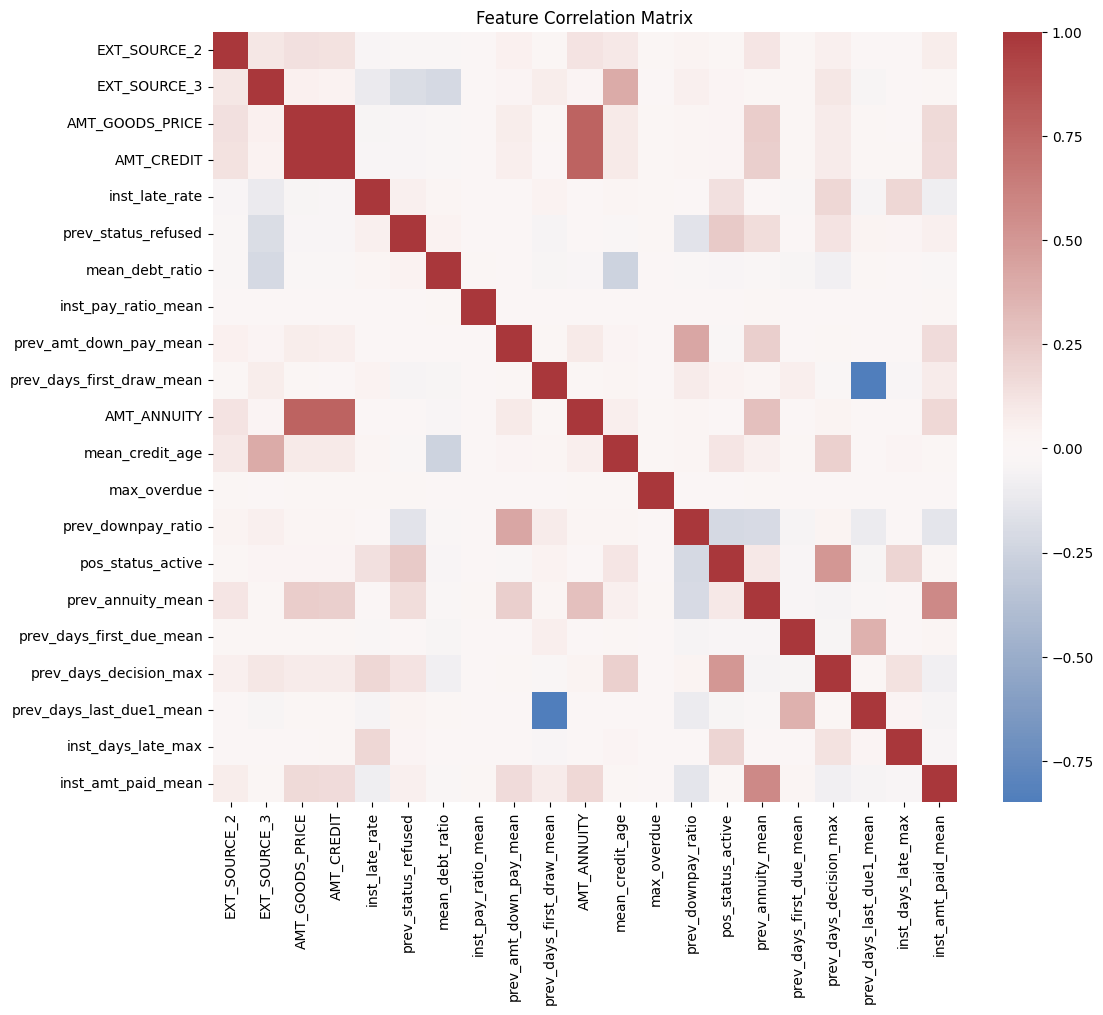

Explained variance by PC: [0.75088731 0.20524952 0.02520621 0.00849937 0.00495956]


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


cluster
0    0.0886
1    0.0515
2    0.0764
3    0.0000
Name: TARGET, dtype: float64


In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# assume pdf is your sampled Pandas DataFrame of top_shap_feats + TARGET

# 1a) Correlation heatmap
corr = pdf[numeric_feats].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="vlag", center=0, annot=False)
plt.title("Feature Correlation Matrix")
plt.show()

# 1b) PCA for dimensionality reduction
pca = PCA(n_components=5)
pcs = pca.fit_transform(pdf[numeric_feats].fillna(0))
print("Explained variance by PC:", pca.explained_variance_ratio_)

# 1c) K-Means clustering on PCs
kmeans = KMeans(n_clusters=4, random_state=0).fit(pcs)
pdf["cluster"] = kmeans.labels_

# 1d) Cluster vs. default rate
print(pdf.groupby("cluster")[TARGET_COL].mean())


## Feature Correlation Matrix Summary

The heatmap above visualizes the **pairwise Pearson correlation coefficients** between selected numeric features in the dataset. Key takeaways include:

### Strong Positive Correlations
- **EXT_SOURCE_2 and EXT_SOURCE_3**: Highly positively correlated, suggesting redundancy between these two external scores.
- **AMT_CREDIT and AMT_GOODS_PRICE**: Strong correlation, as expected since the credit amount is often tied to the goods being purchased.
- **inst_pay_ratio_mean and inst_amt_paid_mean**: Moderate to strong correlation, indicating that higher payment ratios are often associated with higher payment amounts.

### Low or No Correlation
- Many features show low or near-zero correlation, indicating they contribute distinct information (e.g., `EXT_SOURCE_2` vs. `prev_downpay_ratio`).

### Negative Correlations
- A few weak negative correlations are visible (e.g., `prev_status_refused` and `prev_downpay_ratio`), but no strong inverse relationships are dominant.

### Implications
- **Redundant features** (highly correlated pairs) may be candidates for dimensionality reduction or feature selection to avoid multicollinearity.
- **Diverse feature set**: The generally low correlations between most features support the inclusion of many variables in modeling without major overlap in signal.

---

The correlation matrix is a useful tool for **feature engineering**, **data cleaning**, and **model interpretation**.


In [101]:
import scipy.stats as st

for f in numeric_feats:
    z = np.abs(st.zscore(pdf[f].fillna(pdf[f].median())))
    outliers = (z > 3).sum()
    pct = outliers / len(pdf) * 100
    print(f"{f}: {outliers} outliers ({pct:.2f}%)")


EXT_SOURCE_2: 0 outliers (0.00%)
EXT_SOURCE_3: 0 outliers (0.00%)
AMT_GOODS_PRICE: 4173 outliers (1.36%)
AMT_CREDIT: 3255 outliers (1.06%)
inst_late_rate: 6509 outliers (2.12%)
prev_status_refused: 5530 outliers (1.80%)
mean_debt_ratio: 168 outliers (0.05%)
inst_pay_ratio_mean: 152 outliers (0.05%)
prev_amt_down_pay_mean: 2597 outliers (0.84%)
prev_days_first_draw_mean: 8980 outliers (2.92%)
AMT_ANNUITY: 2959 outliers (0.96%)
mean_credit_age: 2704 outliers (0.88%)
max_overdue: 130 outliers (0.04%)
prev_downpay_ratio: 6546 outliers (2.13%)
pos_status_active: 5740 outliers (1.87%)
prev_annuity_mean: 5209 outliers (1.69%)
prev_days_first_due_mean: 6758 outliers (2.20%)
prev_days_decision_max: 0 outliers (0.00%)
prev_days_last_due1_mean: 2775 outliers (0.90%)
inst_days_late_max: 3039 outliers (0.99%)
inst_amt_paid_mean: 4300 outliers (1.40%)


In [ ]:
pdf.to_csv('pdf.csv') # Export the dataframe to csv to continue working in other notebook

# Outcome of EDA and Feature Reduction

## application_train

## Dataset Overview

- **Rows:** 307 511  
- **Columns:** 122  
- **Numeric features:** 106  
- **Categorical features:** 16  
- **Total missing values:** 764 371 (≈ 2.0% of all cells)  
- **Duplicate rows:** 0  

---

## Significant & Interesting Insights

### 1. Imbalanced Target  
- Only **5.7%** of clients default (`TARGET = 1`), indicating a heavily skewed target distribution.

### 2. High-Missing-Rate Features  
Several categorical fields have very high missing rates and will require special handling:  
- **FONDKAPREMONT_MODE:** 68.4% missing  
- **HOUSETYPE_MODE:** 50.2% missing  
- **WALLSMATERIAL_MODE:** 50.8% missing  
- **EMERGENCYSTATE_MODE:** 47.4% missing  
- **OCCUPATION_TYPE:** 31.3% missing  

### 3. Extremely Skewed Variables  
Some features show extreme skewness, which may benefit from log or rank transforms:  
- **AMT_INCOME_TOTAL** (skew ≈ 392)  
- **FLAG_MOBIL**, **FLAG_CONT_MOBILE**, and several `FLAG_DOCUMENT_*` indicators  

### 4. Strong Feature Correlations  
Pairs/groups of variables that nearly duplicate each other:  
- **CNT_CHILDREN** ↔ **CNT_FAM_MEMBERS**  
- **OBS_30_CNT_SOCIAL_CIRCLE** ↔ **OBS_60_CNT_SOCIAL_CIRCLE**  
- **DEF_30_CNT_SOCIAL_CIRCLE** ↔ **DEF_60_CNT_SOCIAL_CIRCLE**  
- **AMT_CREDIT** ↔ **AMT_ANNUITY**, **AMT_GOODS_PRICE**  
- Certain `FLAG_DOCUMENT` pairs (e.g. `FLAG_DOCUMENT_3` ↔ `FLAG_DOCUMENT_8`)  

> **Action:** Consider combining or dropping one of each correlated pair to reduce multicollinearity.

### 5. High-Cardinality Categorical  
- **ORGANIZATION_TYPE**: 58 distinct categories  
  > **Tip:** Group rare types or use target/impact encoding.

---
 


## Enriched Dataset (After Cut down features)

# EDA Summary Report

## Dataset Overview

- **Total Variables**: 31 (30 features + `TARGET`)
- **Target Variable**: `TARGET` (binary: `0` = non-default, `1` = default)
- **Feature Types**: Mostly numeric, with some binary/categorical indicators
- **Missing Values**: Found in key predictors like `EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3`
- **Duplicates**: None detected
- **Memory Footprint**: Moderate (tens of megabytes)

---

## Key Business Insights

### 1. External Credit Scores Are Strong Predictors of Default
- **Insight**: `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3` are highly correlated with credit default.
- **Impact**: These should be primary inputs for credit risk models. Missing values in these columns indicate elevated risk and may require fallback strategies such as manual review or conservative scoring.

---

### 2. Missing Data Is Informative
- **Insight**: Records with missing `EXT_SOURCE_2` values are more likely to default.
- **Impact**: Missingness is not random—flag such applications. This can be used to create a "data sufficiency" score or trigger enhanced due diligence procedures.

---

### 3. Document Submission Flags Reveal Transparency
- **Insight**: Features like `FLAG_DOCUMENT_3`, `FLAG_DOCUMENT_6` show differences in default rates between groups.
- **Impact**: These features can indicate applicant thoroughness or transparency. Lack of certain documents may be linked to increased credit risk.

---

### 4. Employment and Income Are Secondary Risk Indicators
- **Insight**: Features like `DAYS_EMPLOYED`, `AMT_INCOME_TOTAL`, and `AMT_CREDIT` have weaker but still observable differences between defaulters and non-defaulters.
- **Impact**: These features are useful for refining applicant profiles, determining credit line size, or setting interest rate tiers, though they should be weighted less heavily than external credit scores.

---

### 5. Interaction Effects Add Predictive Power
- **Insight**: Nonlinear interactions between features (e.g., long employment duration combined with low credit score) help identify nuanced risk profiles.
- **Impact**: Using models that capture interactions (such as Explainable Boosting Machine or gradient-boosted trees) can improve prediction accuracy and support regulatory explainability.

---
